In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [ ]:
sns.set_theme(style="whitegrid")

# <b> PREPROCESADO </b>

## <b> Descripción del dataset </b>

Los datos pertenecen a un supermercado que está planeando ofrecer una membresía gold que permite obtener un descuento del 20% sobre todas las compras, al precio promocional de 499$.
Esta oferta es valida solo para los clientes activos, no para los nuevos y esta membresía será propuesta a tráves de llamadas telefonicas.

La **variable de clasificación** es "Respuesta" y se refiere a la respuesta positiva (1) o negativa (0) a la membresía propuesta.

Cargamos el dataset en memoria

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Practicas/Extracción de conocimiento/Proyecto final/superstore_data.csv')

Visualizamos los primeros 5 registros del dataset

In [ ]:
df.head()

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
0,1826,1970,Graduation,Divorced,84835.0,0,0,6/16/2014,0,189,...,111,189,218,1,4,4,6,1,1,0
1,1,1961,Graduation,Single,57091.0,0,0,6/15/2014,0,464,...,7,0,37,1,7,3,7,5,1,0
2,10476,1958,Graduation,Married,67267.0,0,1,5/13/2014,0,134,...,15,2,30,1,3,2,5,2,0,0
3,1386,1967,Graduation,Together,32474.0,1,1,11/5/2014,0,10,...,0,0,0,1,1,0,2,7,0,0
4,5371,1989,Graduation,Single,21474.0,1,0,8/4/2014,0,6,...,11,0,34,2,3,1,2,7,1,0


Y su estructura

In [ ]:
df.shape

(2240, 22)

Podemos empezar mirando un poco las estadisticas descriptivas de las variables para echar un primer vistazo a los valores

In [ ]:
df.describe()

,Id,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.149107,0.009375
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.356274,0.096391
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000


Gracias a la tabla que resume las estadísticas descriptivas, se puede notar fácilmente como también las escalas de referencia cambian mucho (por ejemplo, en algunas columnas hay valores en el orden de miles, en otras menores de 1).

Por esta razón antes de aplicar modelos en los pasos siguientes, estandardizaremos los datos.

En la siguiente tabla podemos ver por cada variable:
- los tipos de variables, si numericas (interas o discretas) o categoricas
- la cardinalidad, o sea cuantas entradas unicas hay por cada variable
- la cantidad de valores nulos

In [ ]:

def analyze_dataframe(df):
    """
    Analyzes a Pandas DataFrame and returns a summary table with data types, cardinality, and null counts.
    """

    summary_data = []
    for col in df.columns:
        dtype = df[col].dtype
        cardinality = df[col].nunique()
        null_count = df[col].isnull().sum()
        summary_data.append([col, dtype, cardinality, null_count])

    summary_df = pd.DataFrame(summary_data, columns=['Atributo', 'Tipo de dato', 'Cardinalidad', 'Valores Nulos'])
    return summary_df

# Assuming 'df' is your DataFrame (as defined in the provided code)
summary_table = analyze_dataframe(df)
summary_table

,Atributo,Tipo de dato,Cardinalidad,Valores Nulos
0,Id,int64,2240,0
1,Year_Birth,int64,59,0
2,Education,object,5,0
3,Marital_Status,object,8,0
4,Income,float64,1974,24
5,Kidhome,int64,3,0
6,Teenhome,int64,3,0
7,Dt_Customer,object,663,0
8,Recency,int64,100,0
9,MntWines,int64,776,0


Esta tabla nos cuenta muchas cosas sobre el dataset:

- hay diferentes tipos de datos: object, interos y flotantes.
- la cardinalidad nos dice que hay algunas columnas con valores binarios y otras con muchas más observaciones.
- la última columna nos enseña que hay una columna con valores nulos que habrá que manejar.

## Preparación del dataset

Cambiamos el type de la columna Dt_Customer de object a datetime

In [ ]:
# Convert 'Dt_Customer' to datetime objects
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%m/%d/%Y')


Quitamos la columna ID del dataset, que no aporta ninguna información util para la analisis.

In [ ]:
df = df.drop(columns=['Id'], axis=1)

## Distribución de variables


Generamos histogramas con curva de densidad y boxplot para darnos cuenta de la distribución original de las variables del dataset.

<Figure size 1000x600 with 0 Axes>

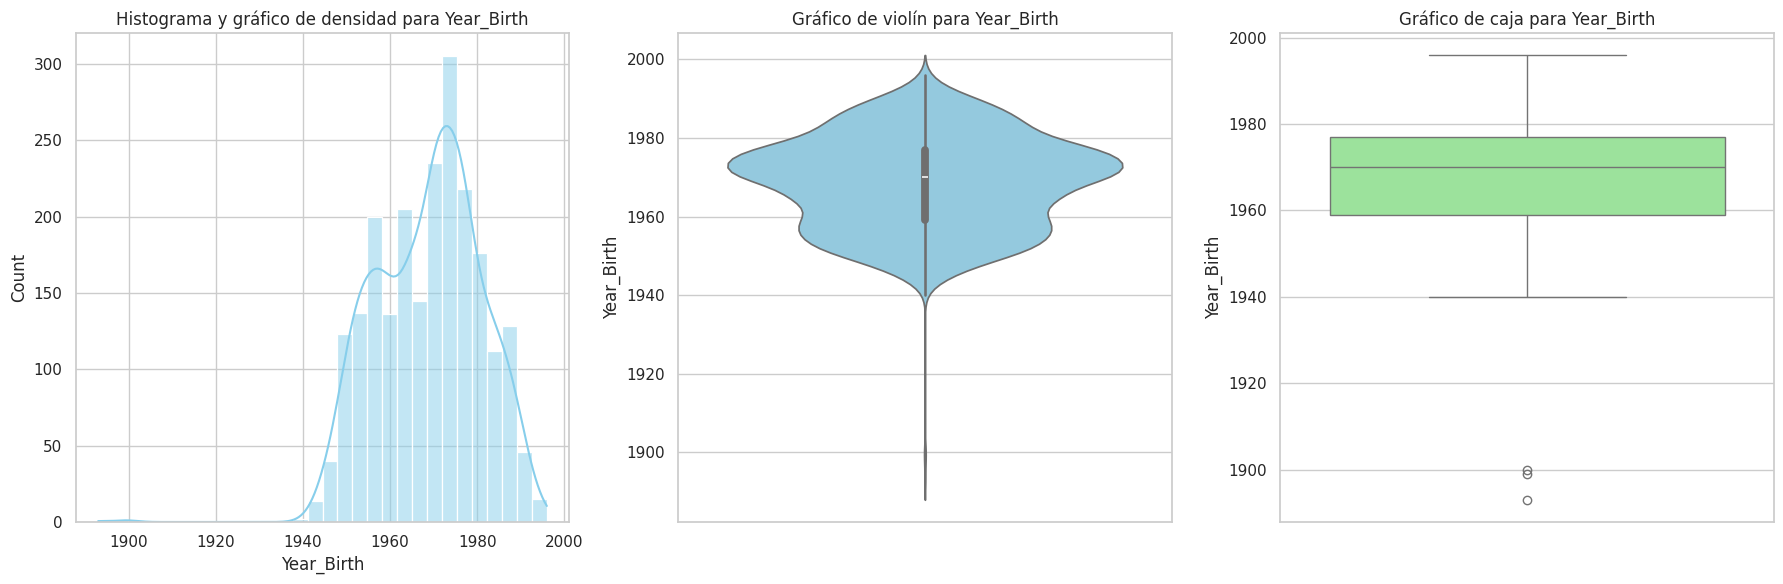

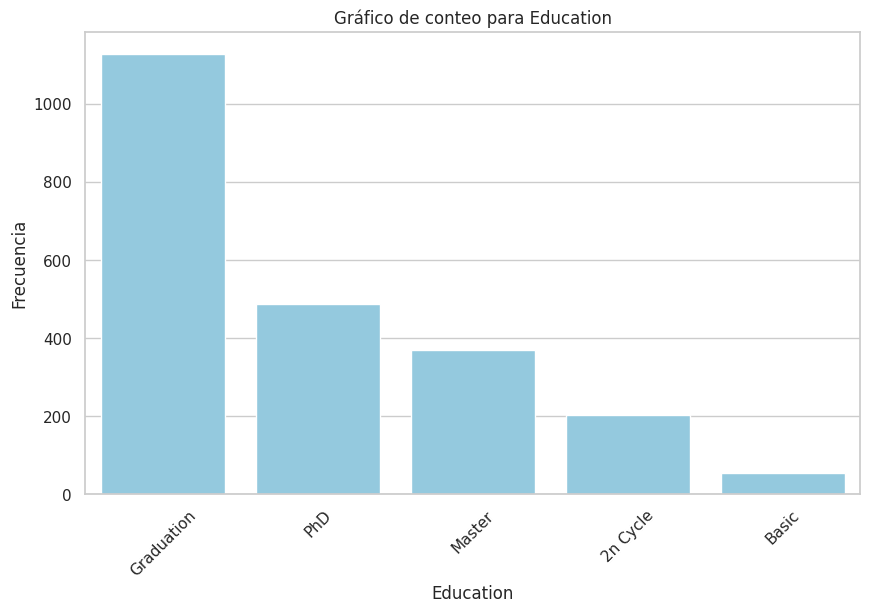

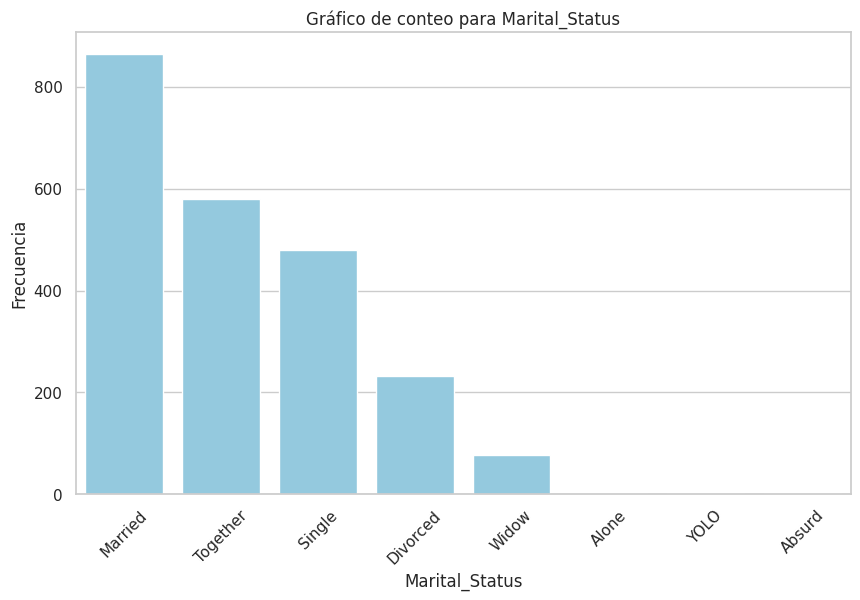

<Figure size 1000x600 with 0 Axes>

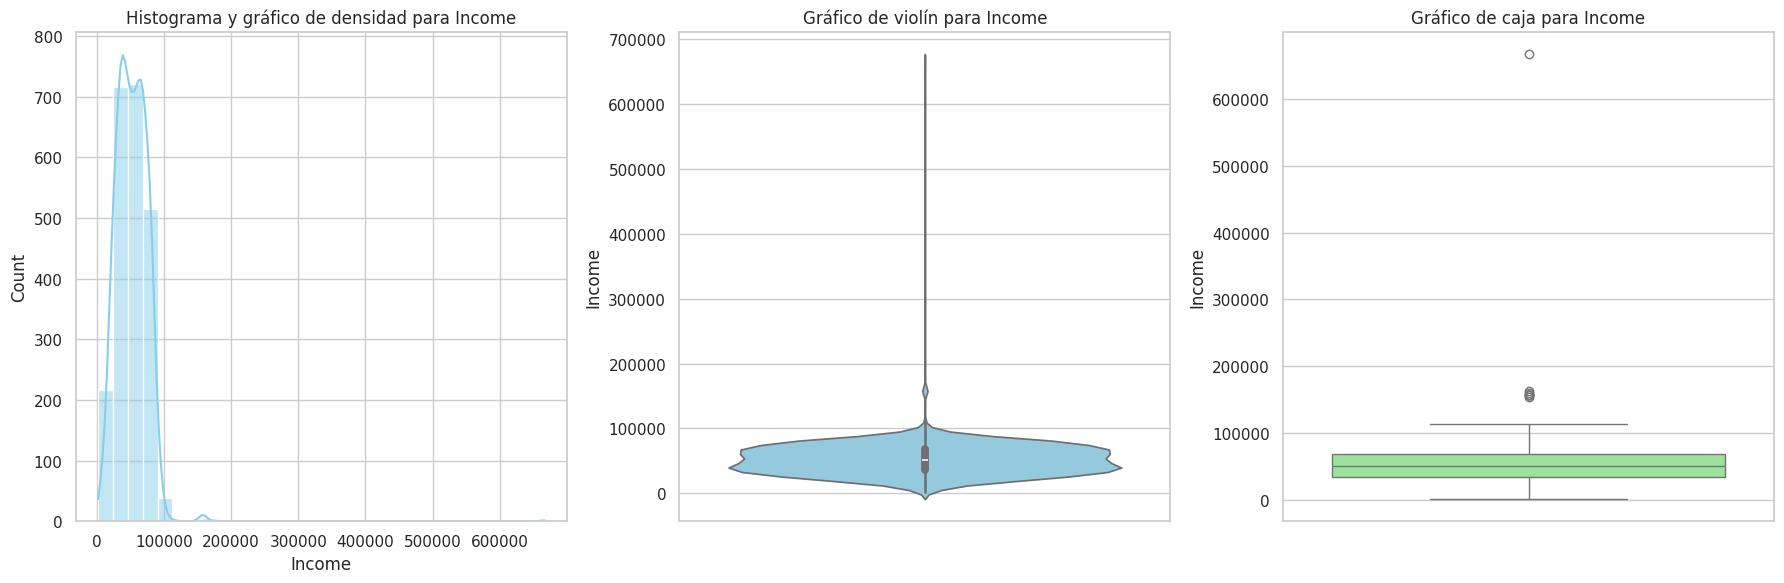

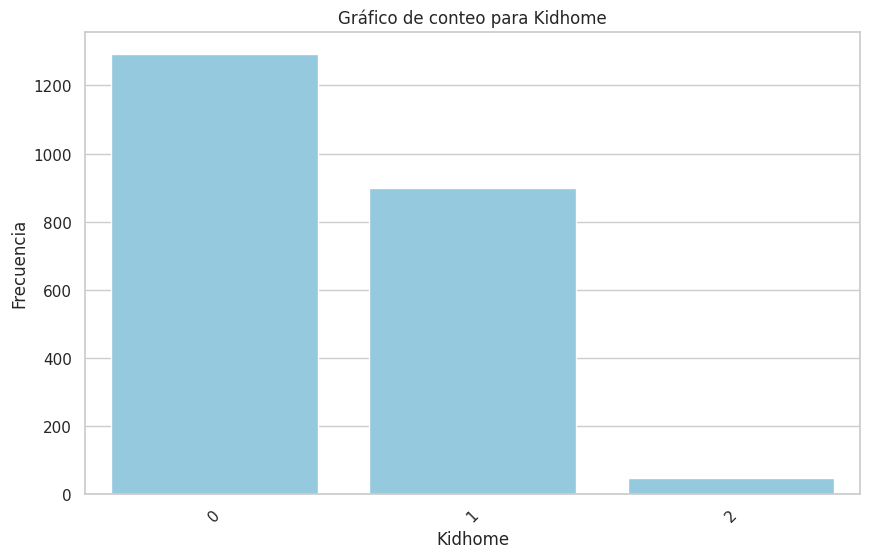

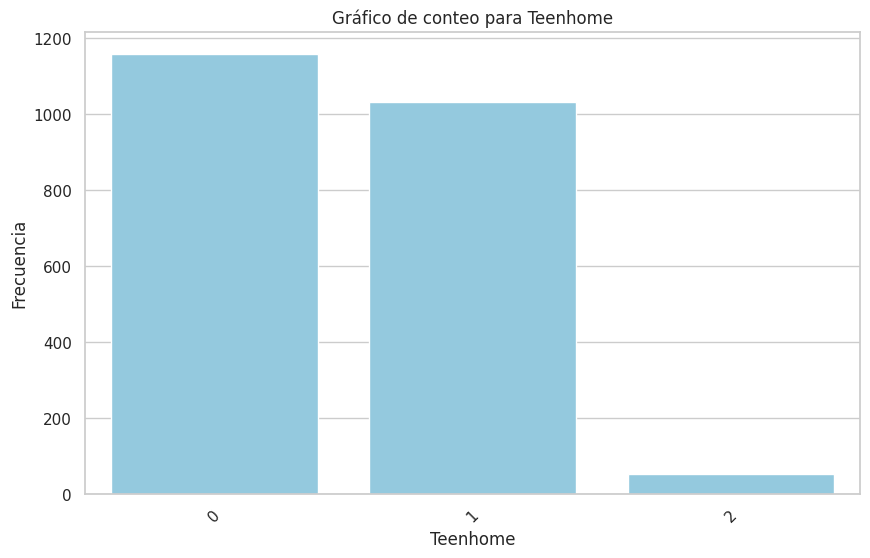

<Figure size 1000x600 with 0 Axes>

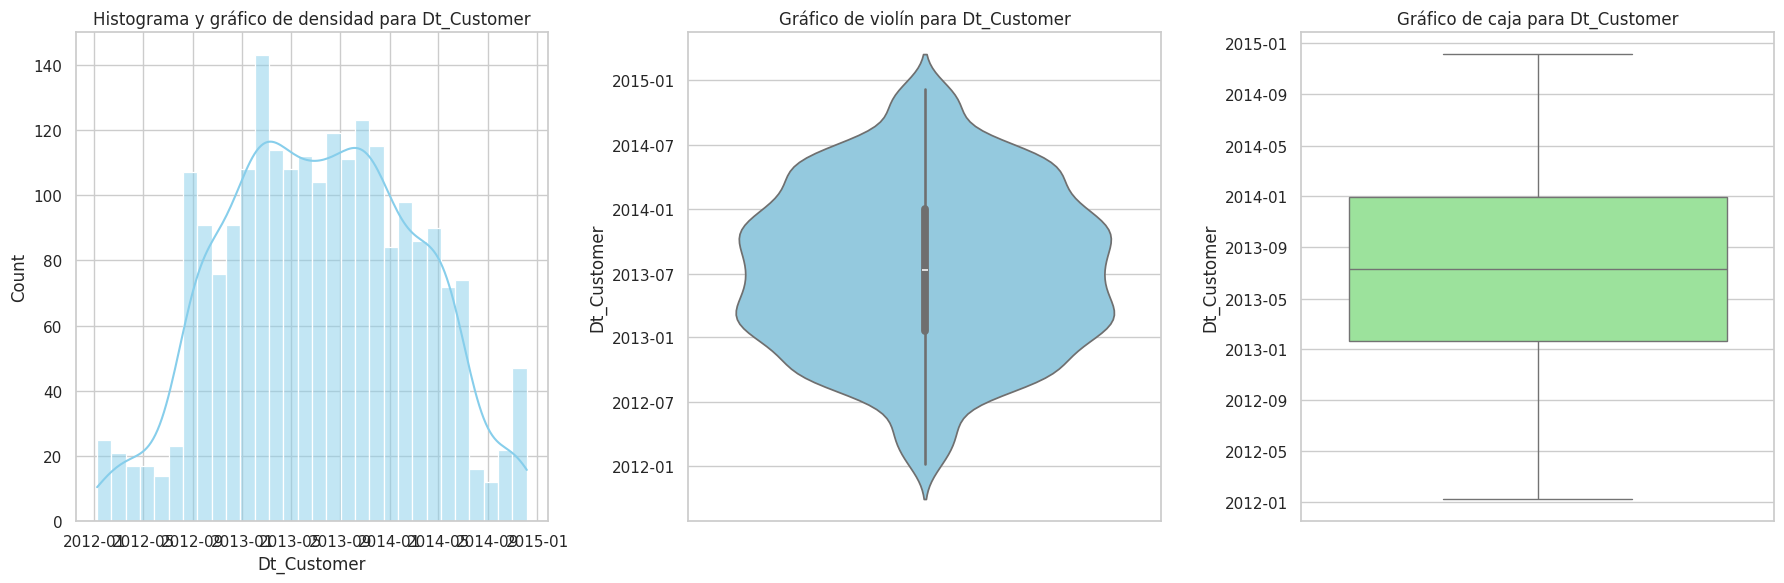

<Figure size 1000x600 with 0 Axes>

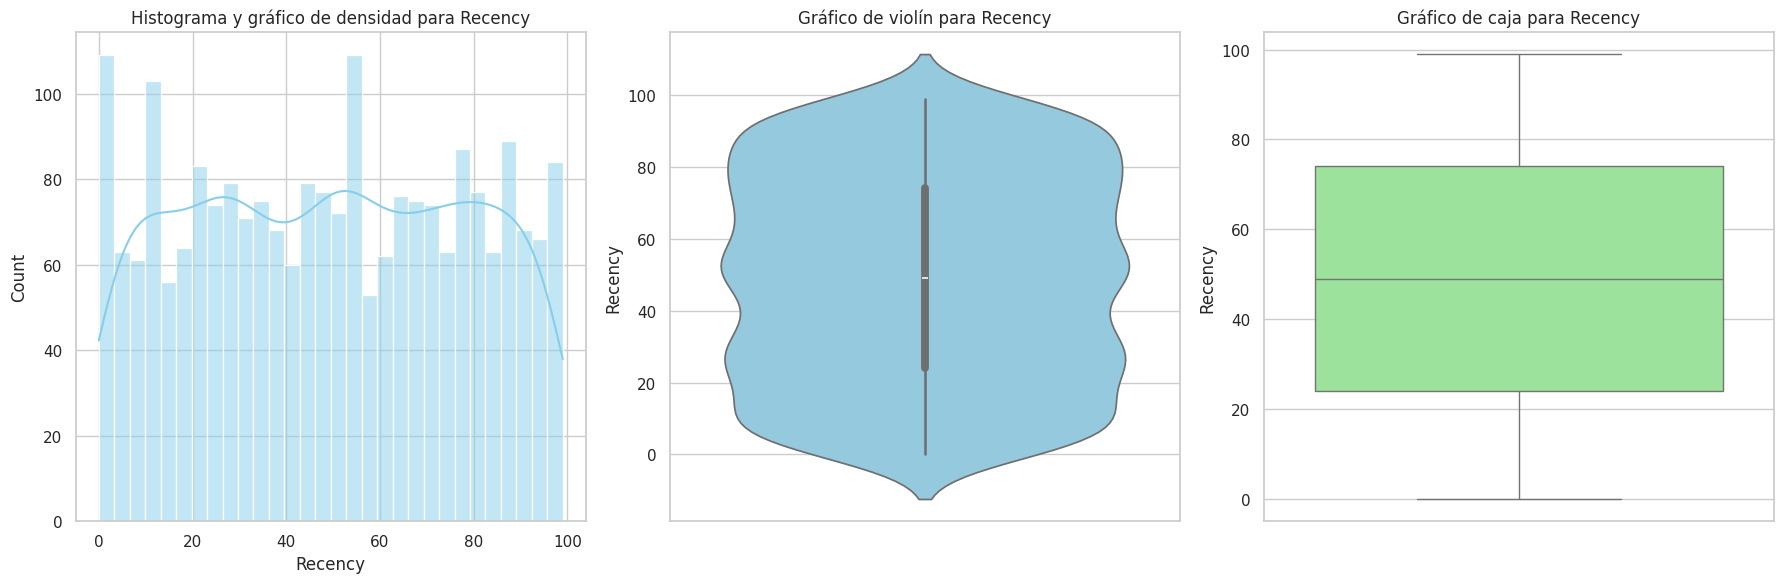

<Figure size 1000x600 with 0 Axes>

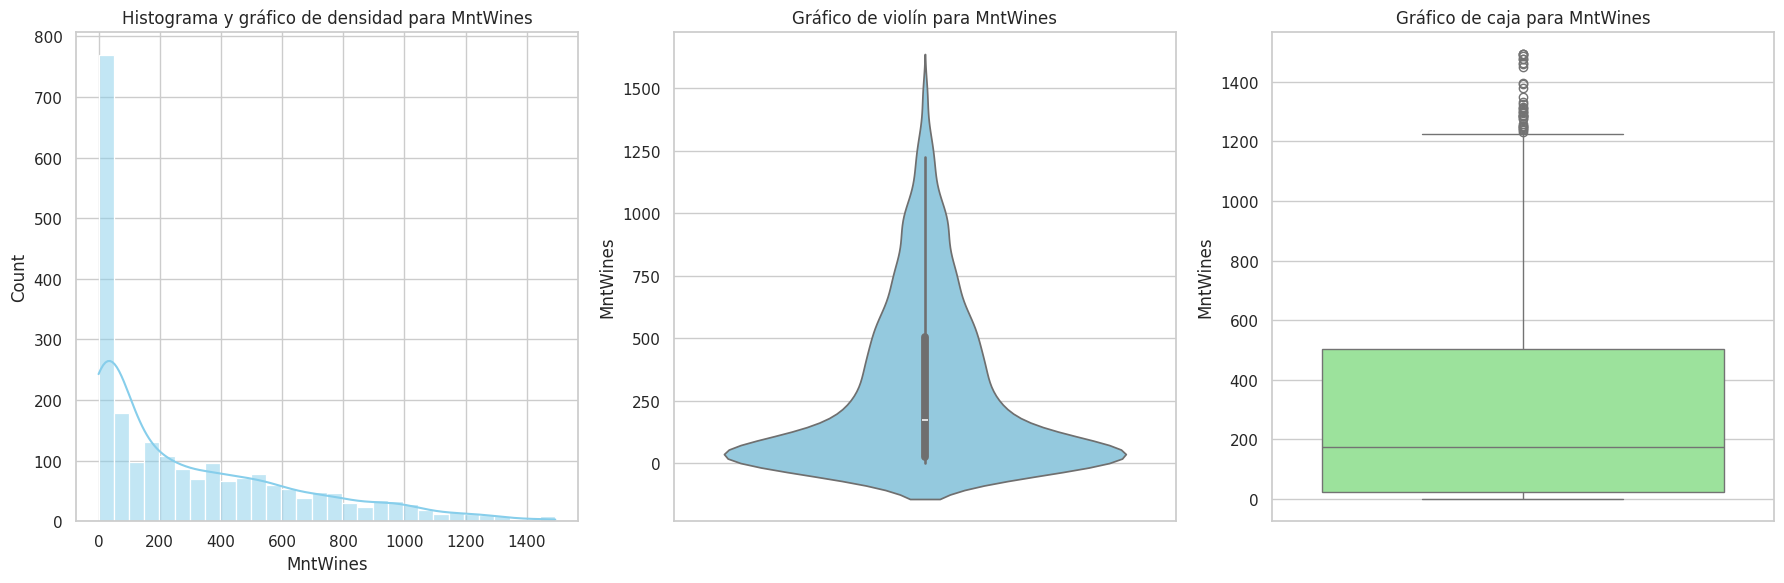

<Figure size 1000x600 with 0 Axes>

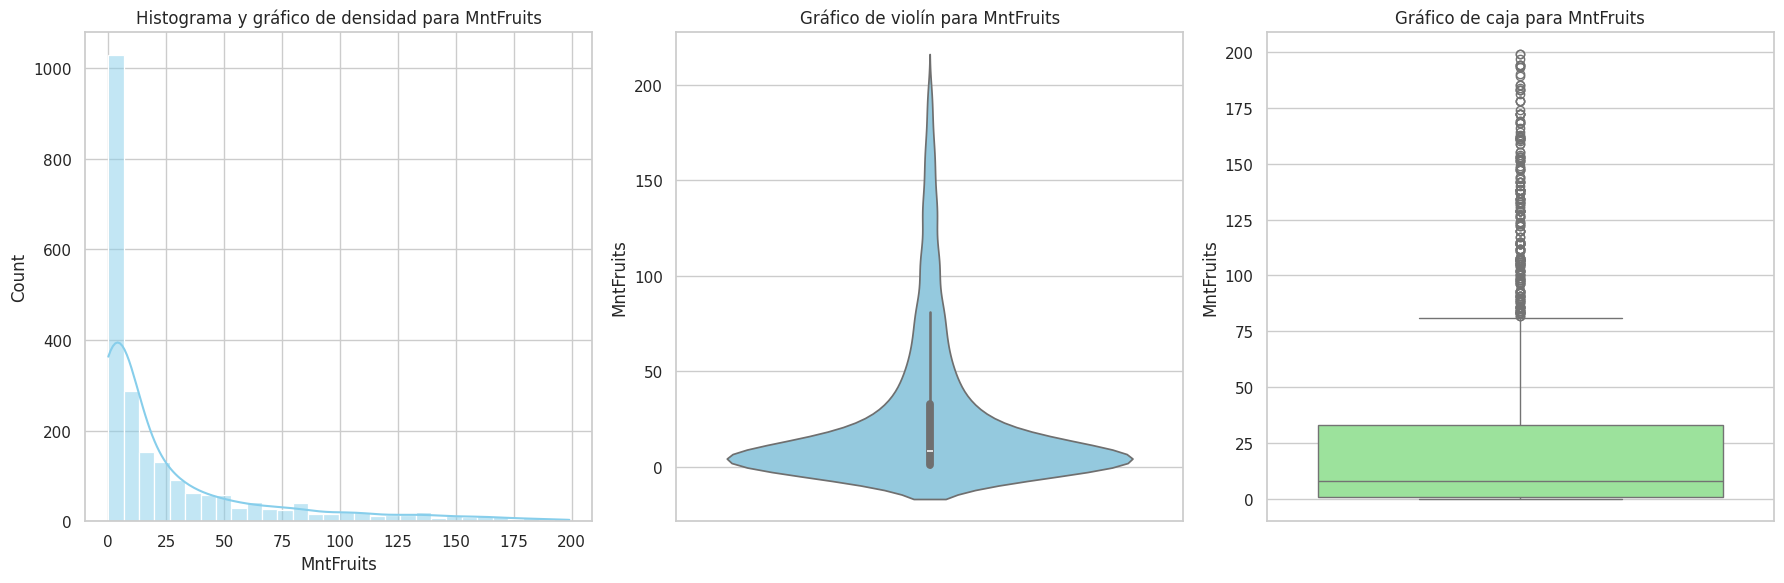

<Figure size 1000x600 with 0 Axes>

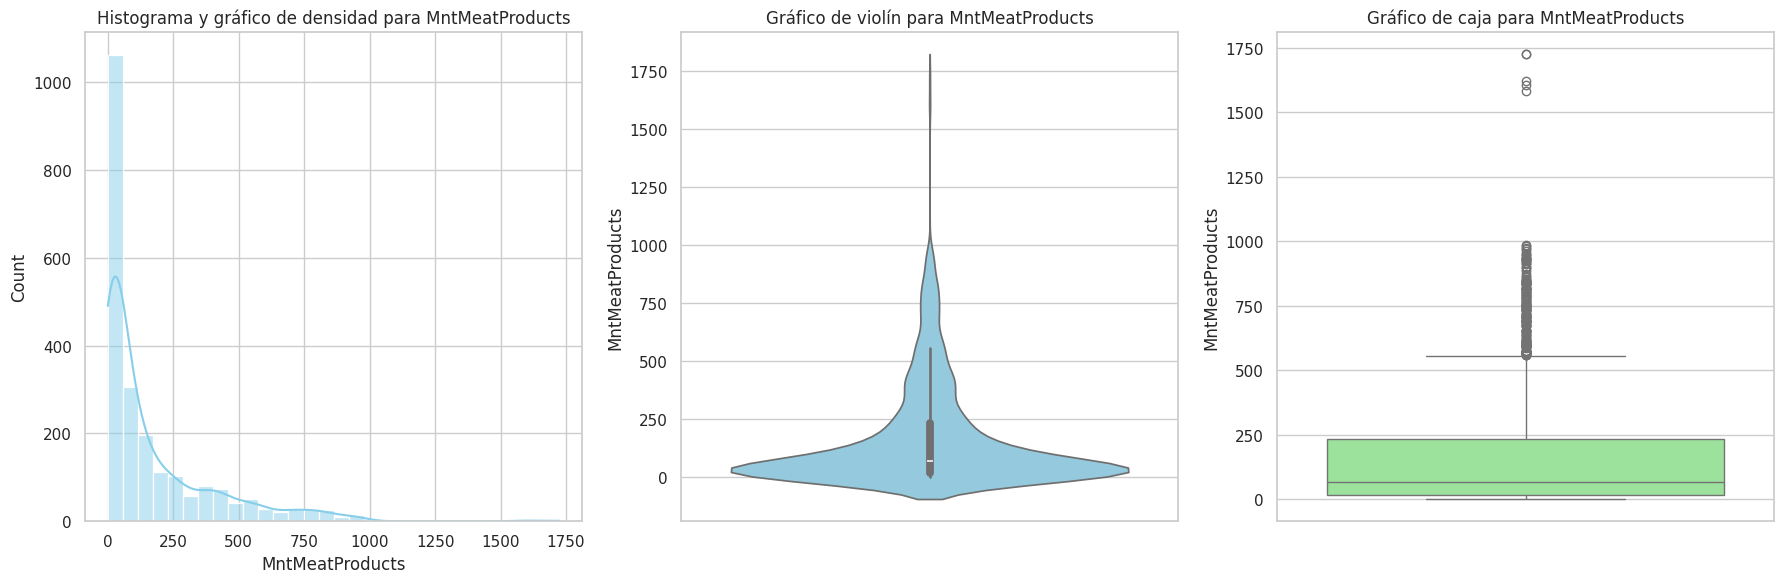

<Figure size 1000x600 with 0 Axes>

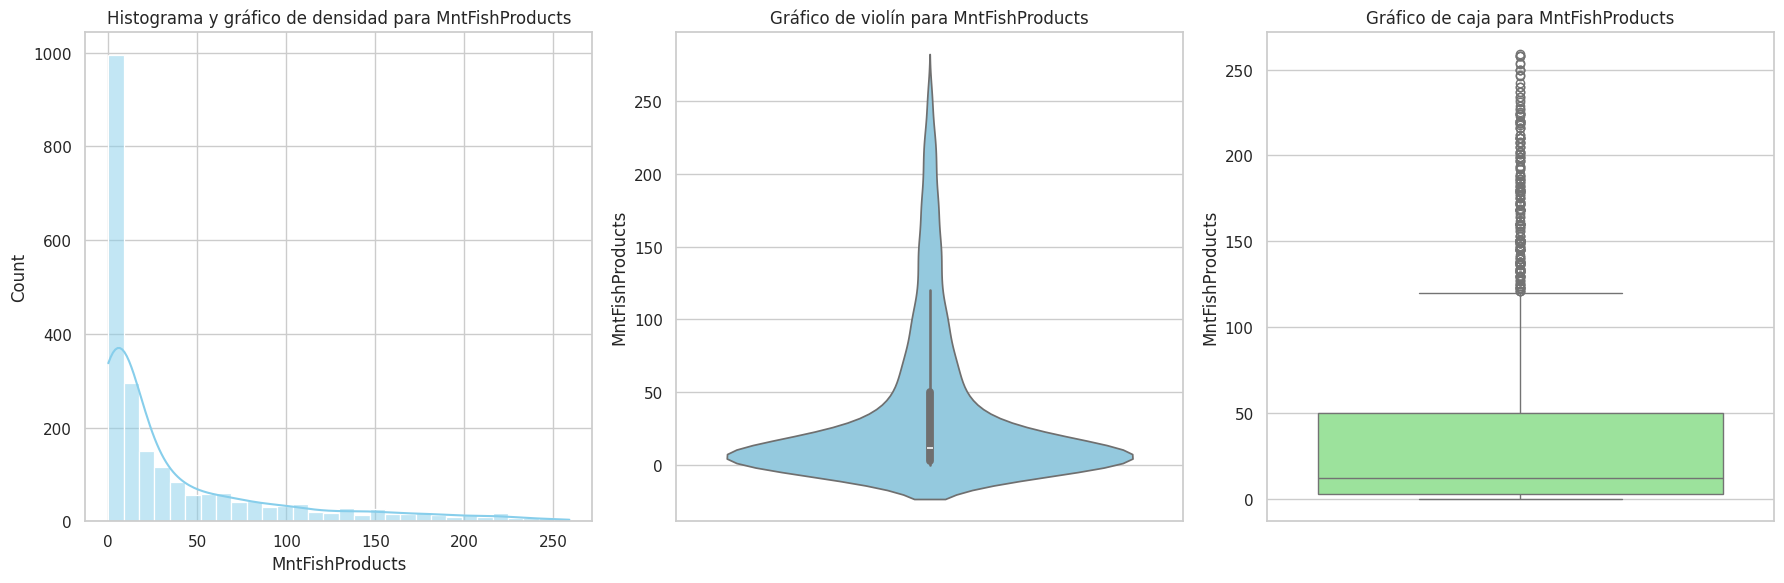

<Figure size 1000x600 with 0 Axes>

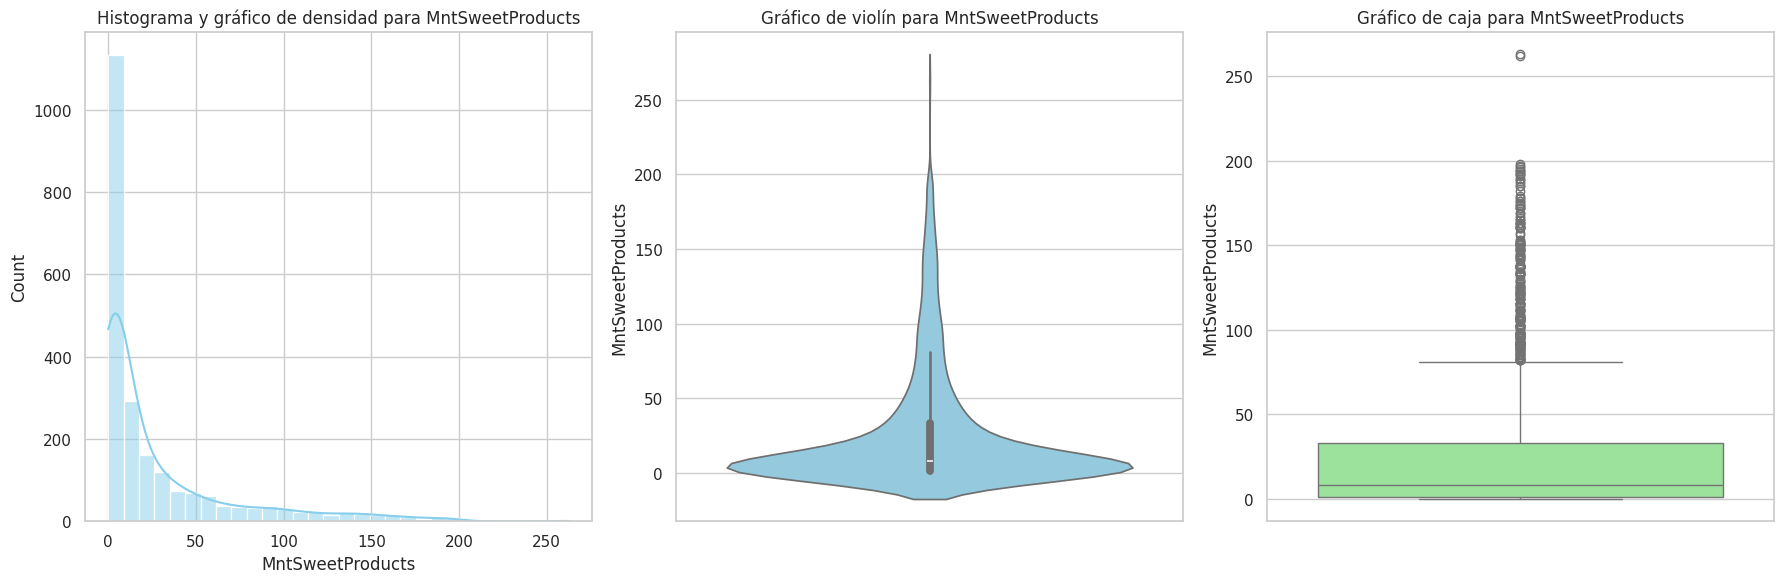

<Figure size 1000x600 with 0 Axes>

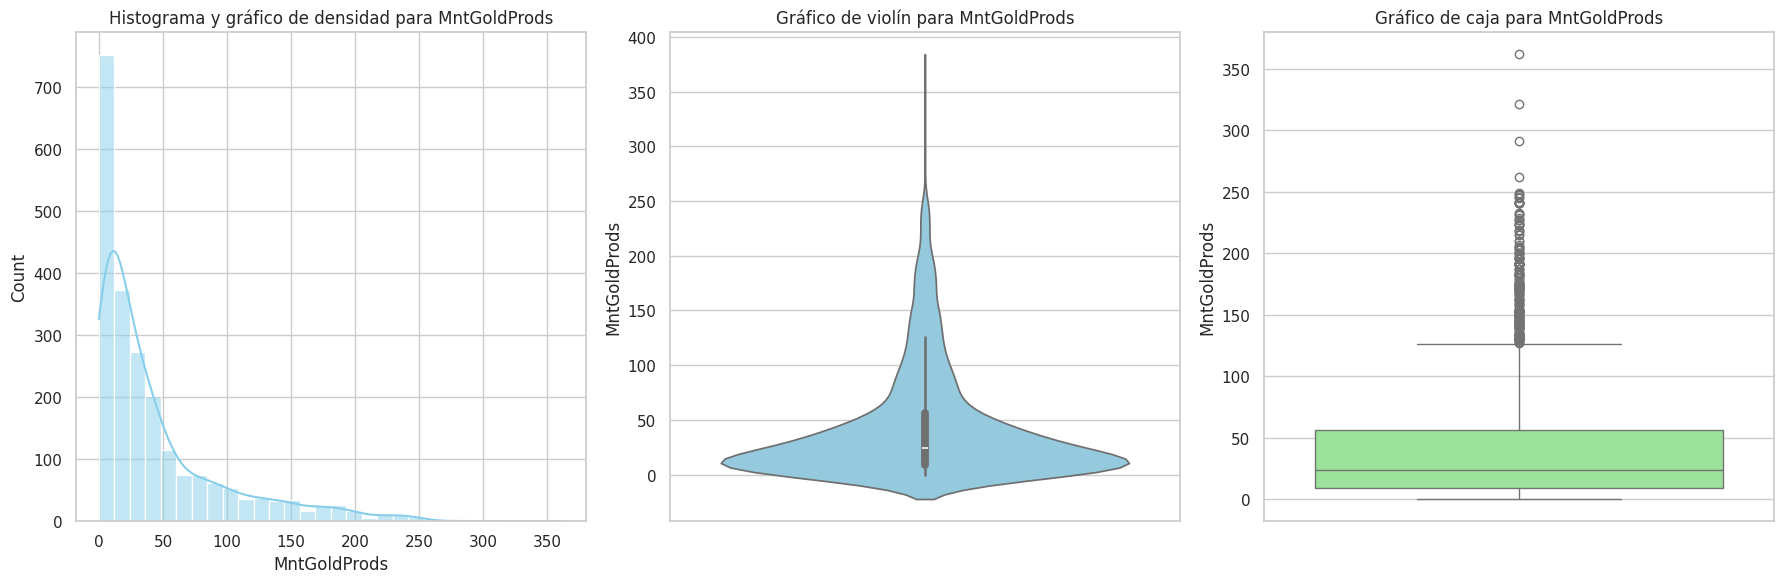

<Figure size 1000x600 with 0 Axes>

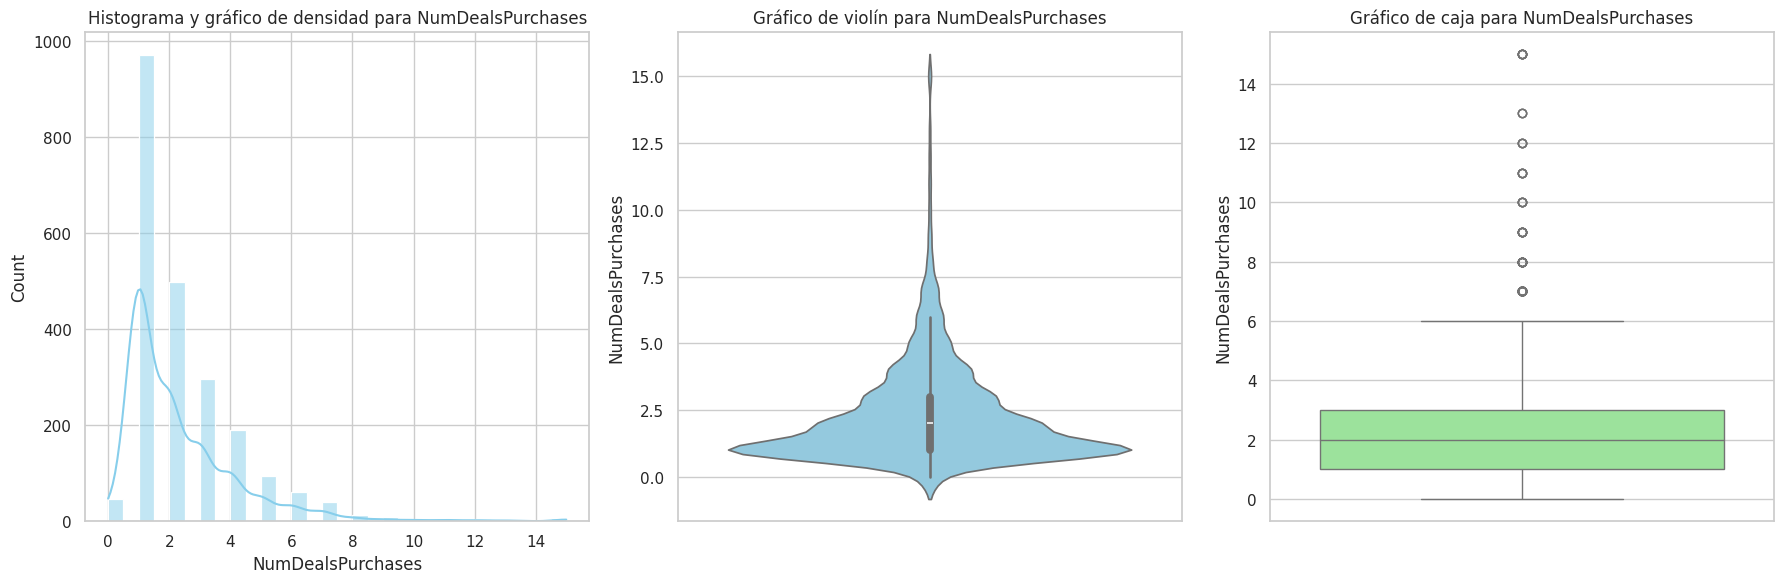

<Figure size 1000x600 with 0 Axes>

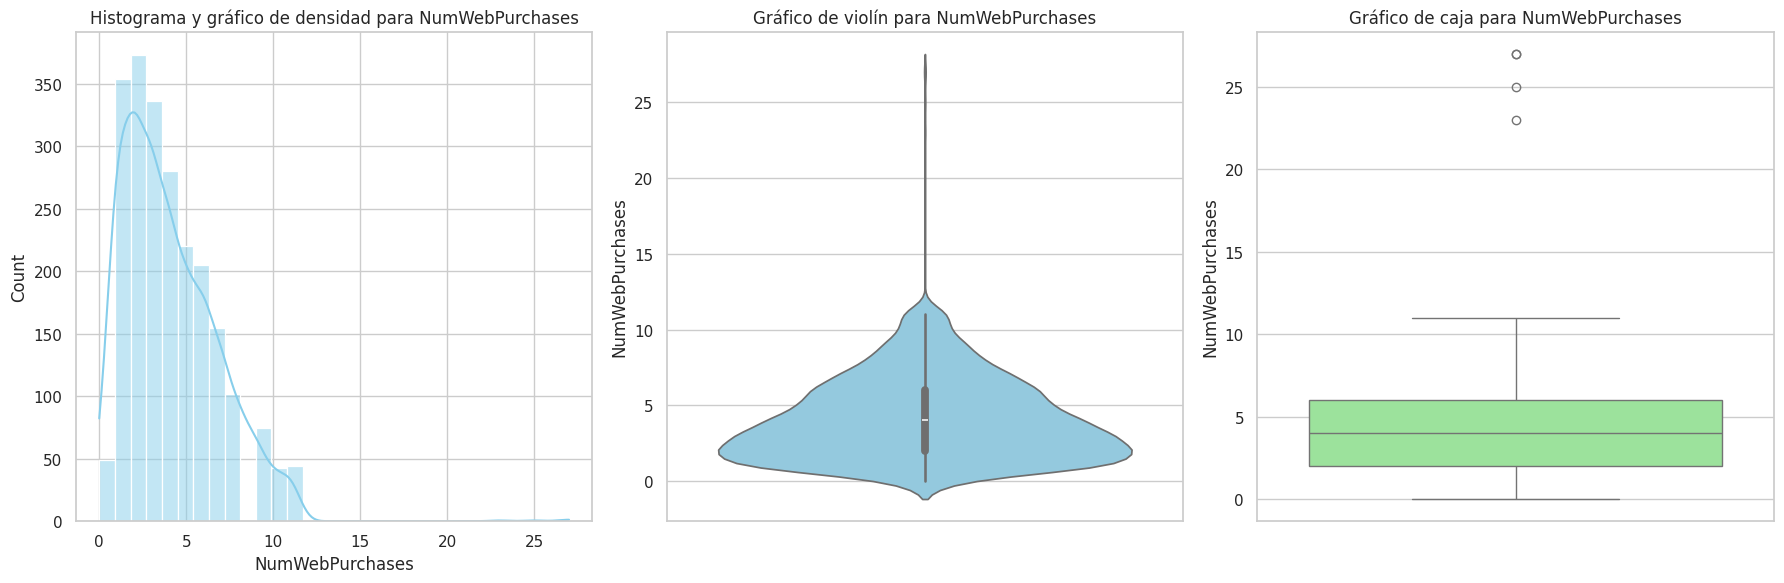

<Figure size 1000x600 with 0 Axes>

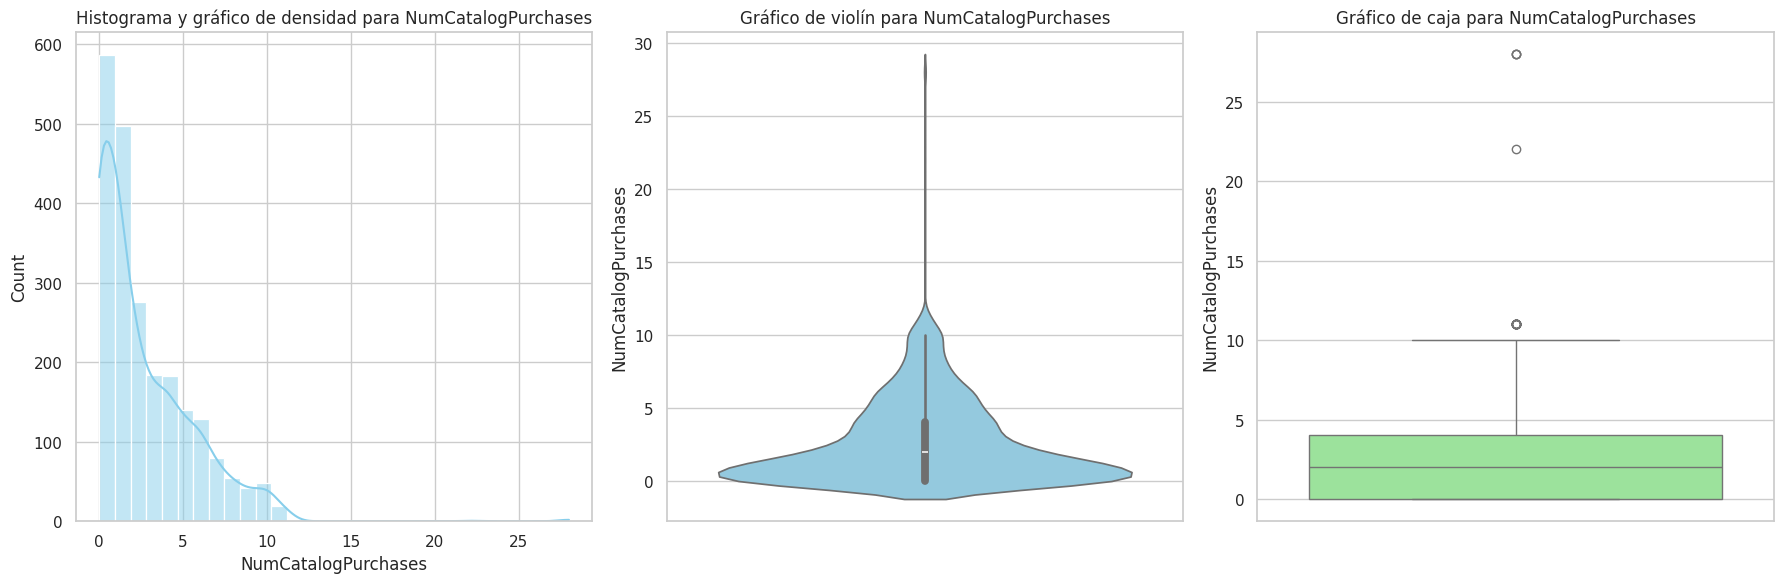

<Figure size 1000x600 with 0 Axes>

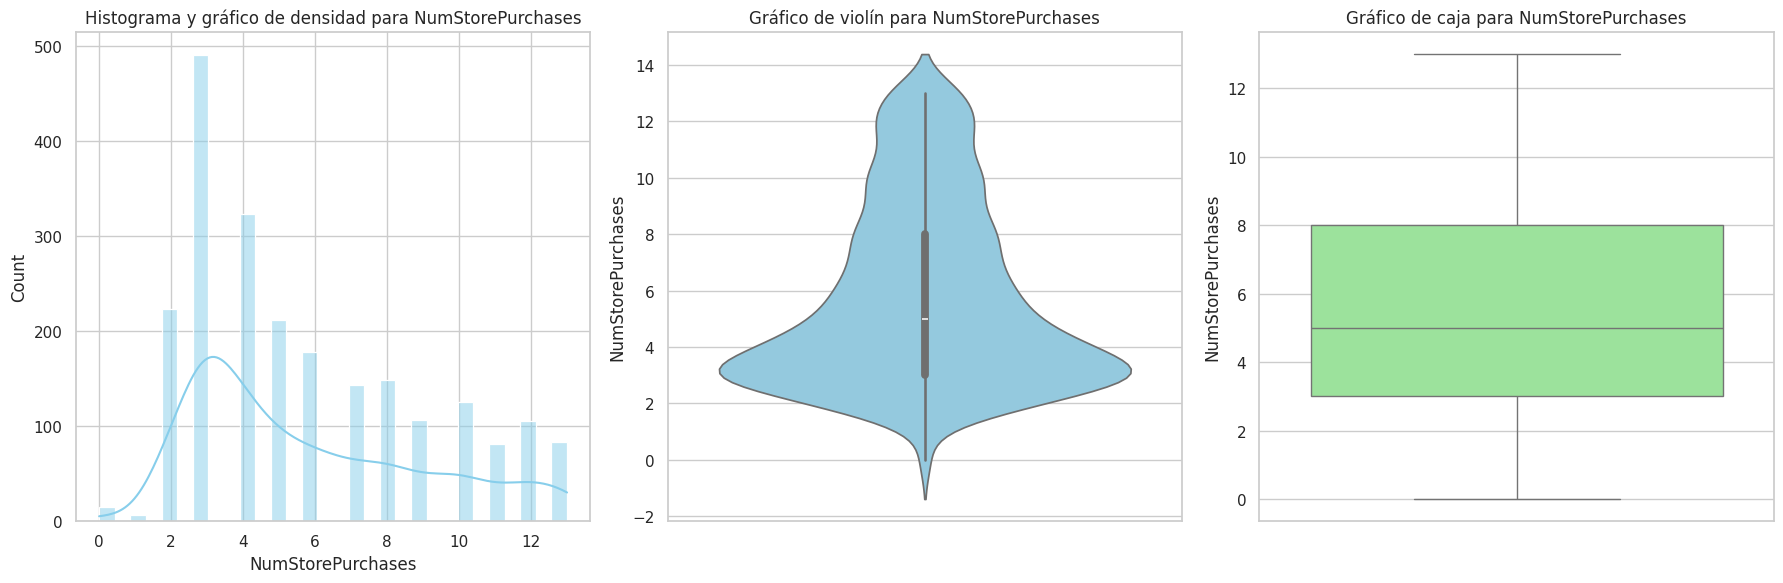

<Figure size 1000x600 with 0 Axes>

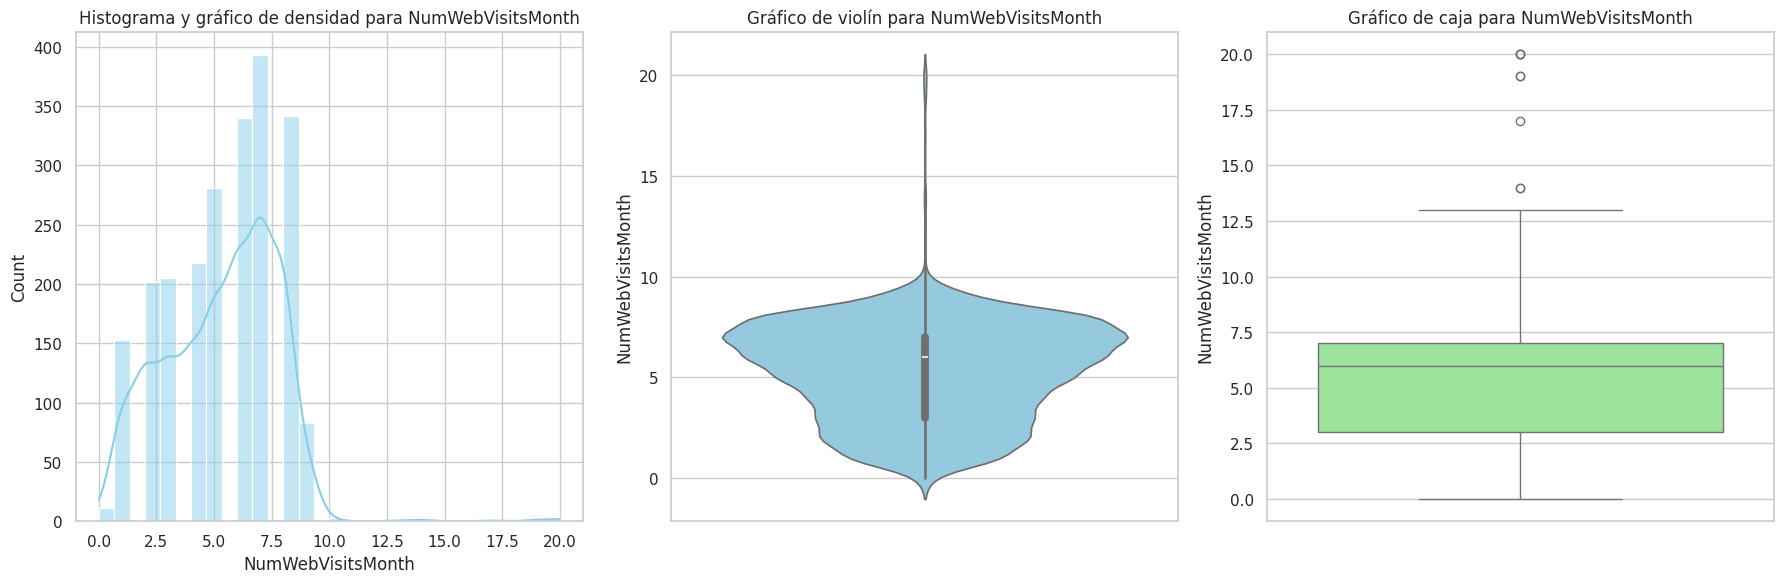

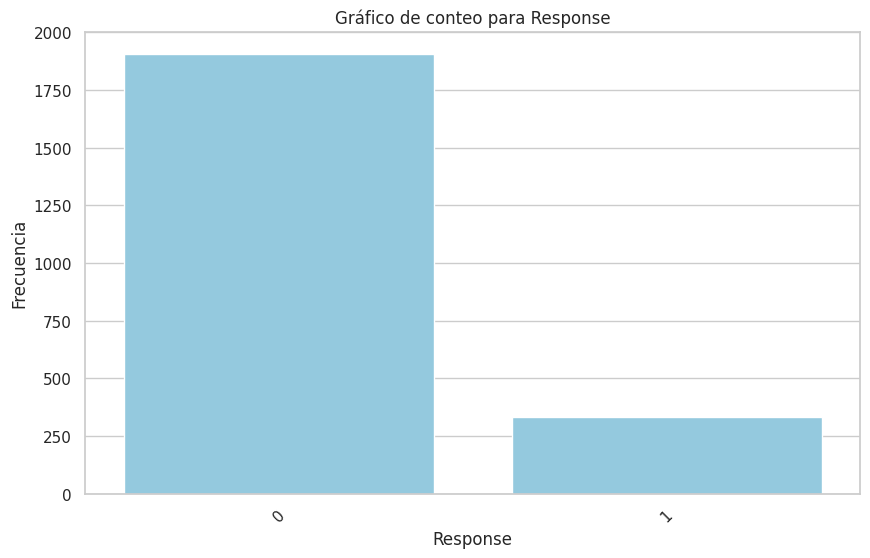

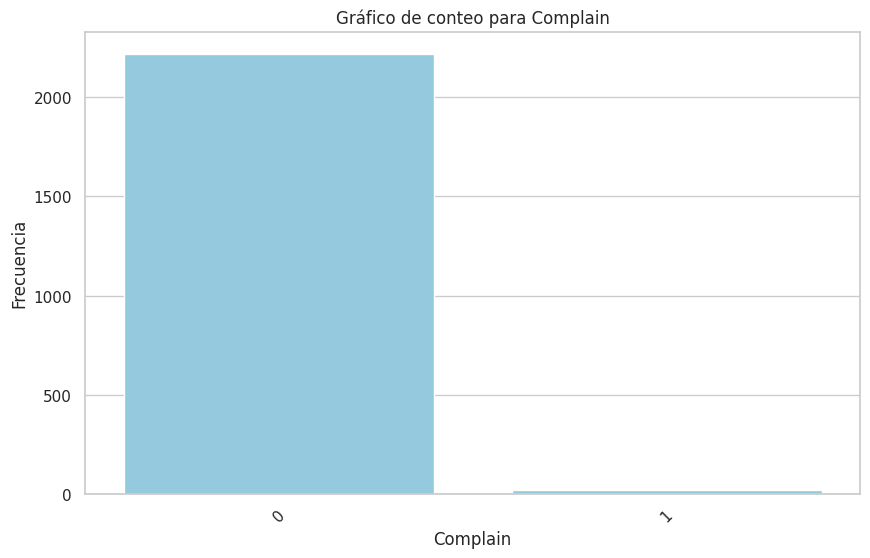

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lista de columnas categóricas o discretas
categorical_or_discrete_cols = ['Response', 'Complain', 'Education',
                               'Marital_Status', 'Kidhome', 'Teenhome']

# Generar gráficos
for col in df.columns:
    plt.figure(figsize=(10, 6))

    if col in categorical_or_discrete_cols:
        # Histograma simple para variables categóricas o discretas
        sns.countplot(x=df[col], color="skyblue", order=df[col].value_counts().index)
        plt.title(f'Gráfico de conteo para {col}')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.xticks(rotation=45)  # Rotar etiquetas si es necesario
    else:
        # Histograma con KDE, Violin Plot y Box Plot para variables numéricas
        plt.figure(figsize=(18, 6))
        plt.subplot(1, 3, 1)
        sns.histplot(df[col], kde=True, bins=30, color='skyblue')
        plt.title(f'Histograma y gráfico de densidad para {col}')

        plt.subplot(1, 3, 2)
        sns.violinplot(y=df[col], color="skyblue")
        plt.title(f'Gráfico de violín para {col}')

        plt.subplot(1, 3, 3)
        sns.boxplot(y=df[col], color="lightgreen")
        plt.title(f'Gráfico de caja para {col}')

        plt.tight_layout()
    plt.show()


Mirando a los graficos, hemos notado como hay una gran cantitad de outliers en algunas variables, lo que las lleva a una fuerte asimetría que luego tendremos que arreglar, por cuanto posible, para que no influya en nuestra analisis.

## Gestión de los valores nulos

Como ya visto en la tabla descriptiva, tenemos valores nulos solo en una columna: la del **Income**.

Para obtener una imputación más fina, hemos decidido imputar el valor promedio **calculandolo por grupos de observaciones**.

Considerando que el Income es una variable sensible al nivel de educación de personas, hemos agrupado por niveles de educación y por cada grupo hemos calculado el income promedio.



In [ ]:
# Calcular el ingreso promedio por nivel educativo
average_income_by_education = df.groupby('Education')['Income'].mean()

# Rellenar los valores NaN en la columna 'Income' utilizando el promedio según el nivel educativo
df['Income'] = df.groupby('Education')['Income'].transform(lambda x: x.fillna(x.mean()))

Comprobamos que ya no hay valores nulos en nuestro dataset






In [ ]:
df.isnull().sum()

,0
Year_Birth,0
Education,0
Marital_Status,0
Income,0
Kidhome,0
Teenhome,0
Dt_Customer,0
Recency,0
MntWines,0
MntFruits,0


## **Limpieza de datos**

### Limpieza de datos categoricos




Observando los valores unicos de las columnas categoricas, nos hemos dado cuenta de que en la columna "Marital Status" habían valores incoherentes.

Por esta razón:
-	Hemos imputado las observaciones con valor “Alone” como “Single”.
-	Hemos borrado las observaciones con "YOLO" y "absurd", en cuanto no teníamos indicios sobre el real estado civil de los interesados y eran muy pocas lineas sobre el total (4).



In [ ]:
# Reemplazar los valores "Alone" por "Single" en la columna 'Marital_Status'
df['Marital_Status'] = df['Marital_Status'].replace('Alone', 'Single')

# Eliminar las filas donde 'Marital_Status' tiene los valores "YOLO" o "Absurd"
df = df[~df['Marital_Status'].isin(['YOLO', 'Absurd'])]


### Limpieza de datos de tipo date

De momento que la cantidad de tiempo es más informativa de la fecha, he utilizado la columna con la fecha (preliminarmente convertida en formato date) para calcular la antigüedad del cliente en unidad de meses (número entero) y he borrado la columna Dt_Customer.  

In [ ]:
# Encontramos la fecha más reciente en la columna 'Dt_Customer'
max_date = df['Dt_Customer'].max()

# Calculamos la antigüedad en meses para cada cliente
df['Antiguedad'] = (max_date - df['Dt_Customer']) / pd.Timedelta(days=30)

# Convertimos la antigüedad a un número entero
df['Antiguedad'] = df['Antiguedad'].astype(int)

df = df.drop('Dt_Customer', axis=1)

df.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Antiguedad
0,1970,Graduation,Divorced,84835.0,0,0,0,189,104,379,...,189,218,1,4,4,6,1,1,0,5
1,1961,Graduation,Single,57091.0,0,0,0,464,5,64,...,0,37,1,7,3,7,5,1,0,5
2,1958,Graduation,Married,67267.0,0,1,0,134,11,59,...,2,30,1,3,2,5,2,0,0,6
3,1967,Graduation,Together,32474.0,1,1,0,10,0,1,...,0,0,1,1,0,2,7,0,0,1
4,1989,Graduation,Single,21474.0,1,0,0,6,16,24,...,0,34,2,3,1,2,7,1,0,4


De la misma manera, he calculado la edad (en años) gracias al año de nacimiento y he borrado la columna "Year_Birth".

In [ ]:
df['Age'] = 2025 - df['Year_Birth']
df = df.drop('Year_Birth', axis=1)

## Transformación de datos  



Para normalizar las curvas de las variables, aplicamos la transformación de Box-Cox, que ayuda a que los datos tengan una distribución más parecida a la normal, reduciendo la asimetría y estabilizando la varianza, lo que mejora el rendimiento de los modelos.

No se aplica a todas las columnas numericas, sino solo a las que tienen una fuerte asimetría

El valor de lambda es el parámetro calculado al aplicar la transformación Box-Cox, y es el que permite que los datos transformados se acerquen lo más posible a una distribución normal.
- Cuando
λ=1: la transformación no modifica los datos
- Cuando
λ < 1: los valores se comprimen, especialmente los más grandes.
- Cuando
λ>1: los valores se expanden.
- Cuando
λ=0: se aplica el logaritmo

In [ ]:
df_transformation = df.copy()

En los siguientes gráficos podemos mirar las distribuciones de las variables sobre las cuales hemos aplicado BoxCox

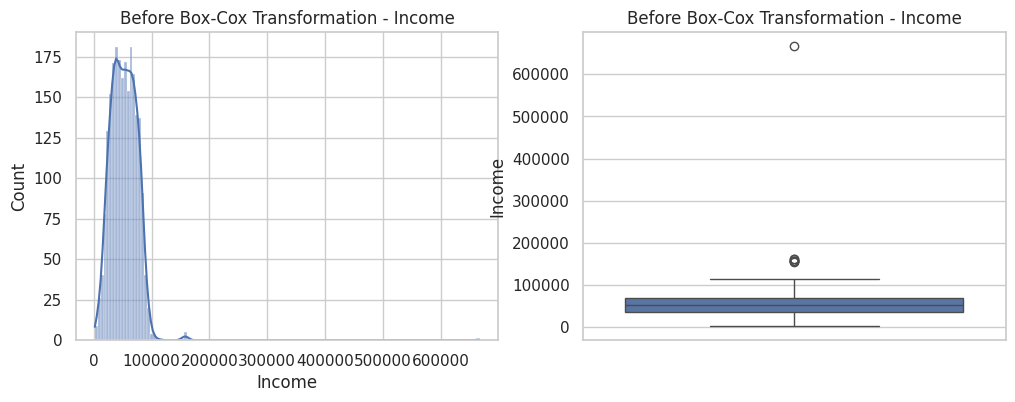

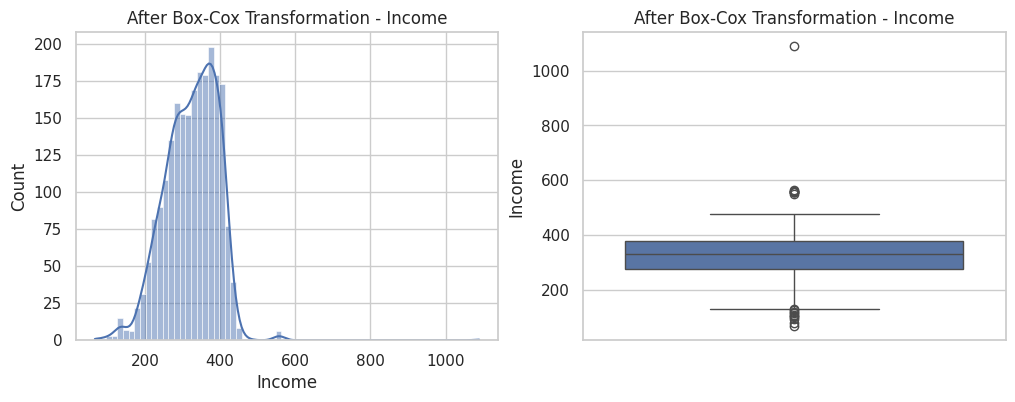

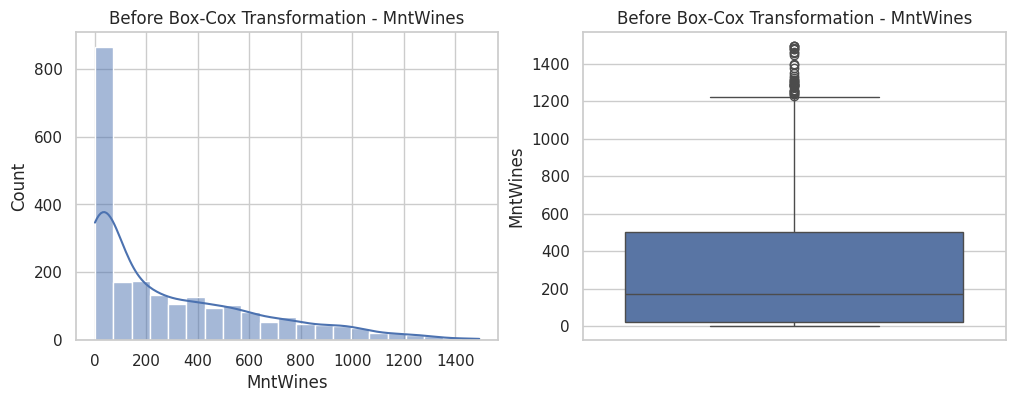

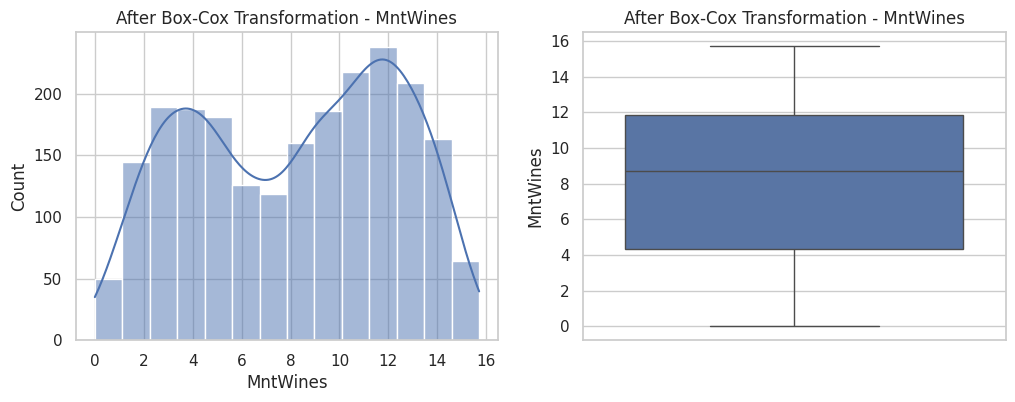

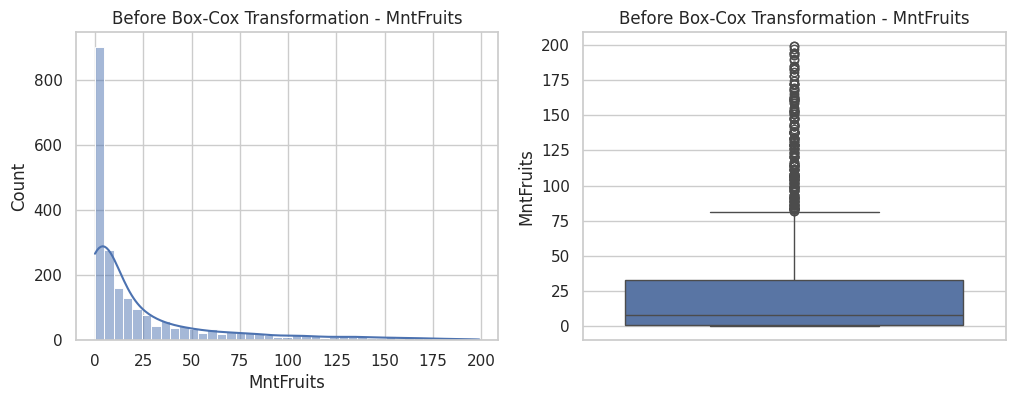

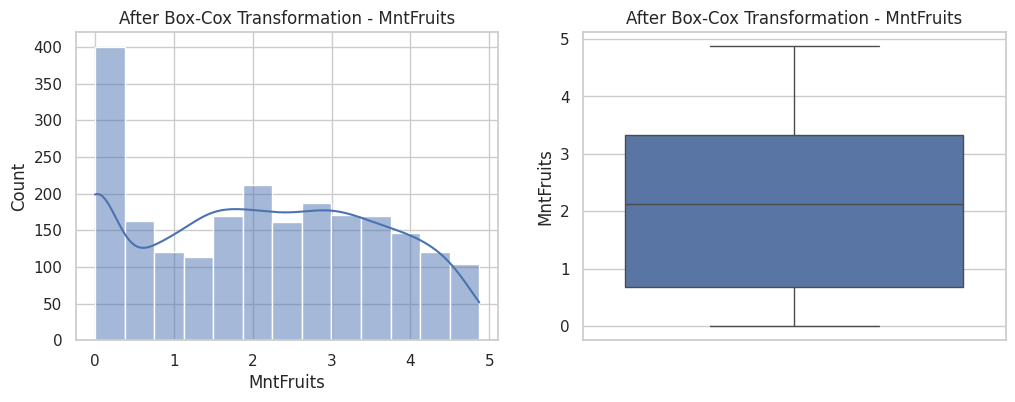

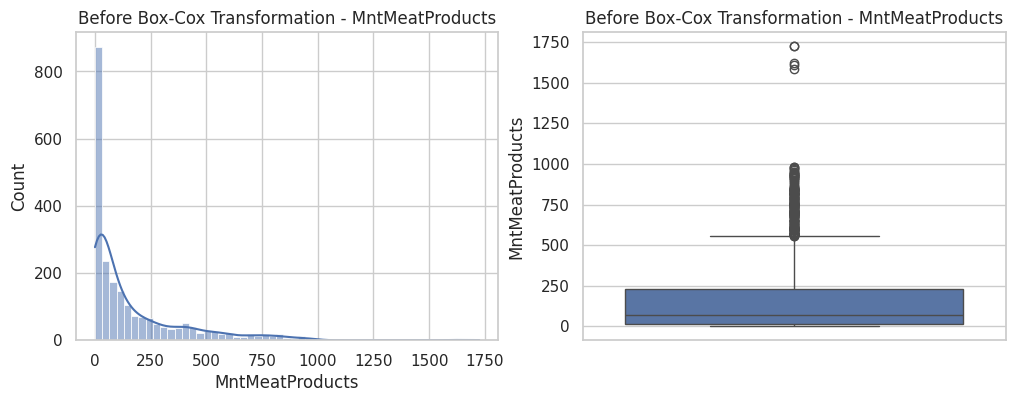

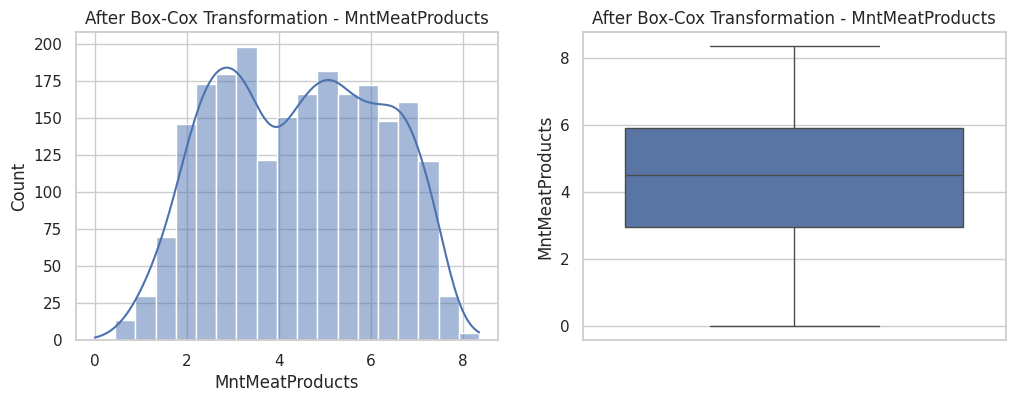

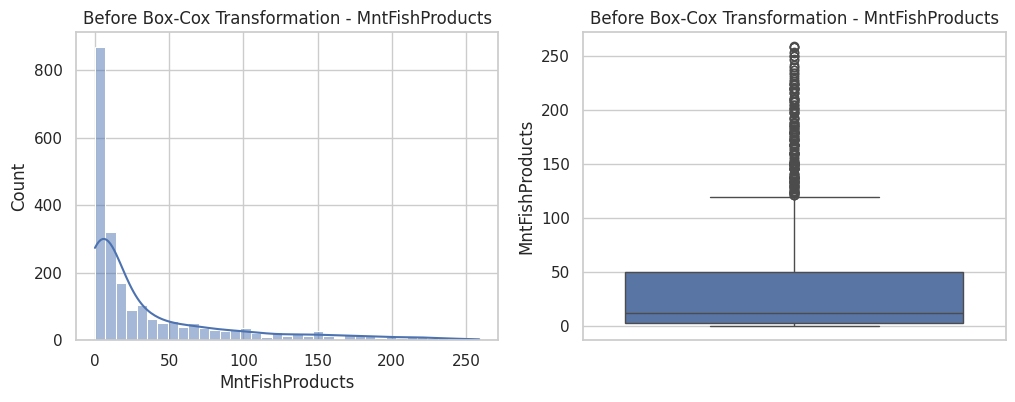

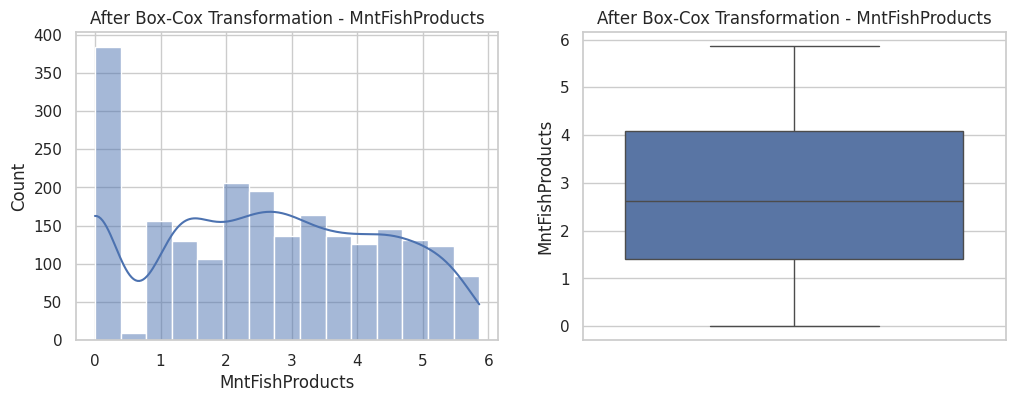

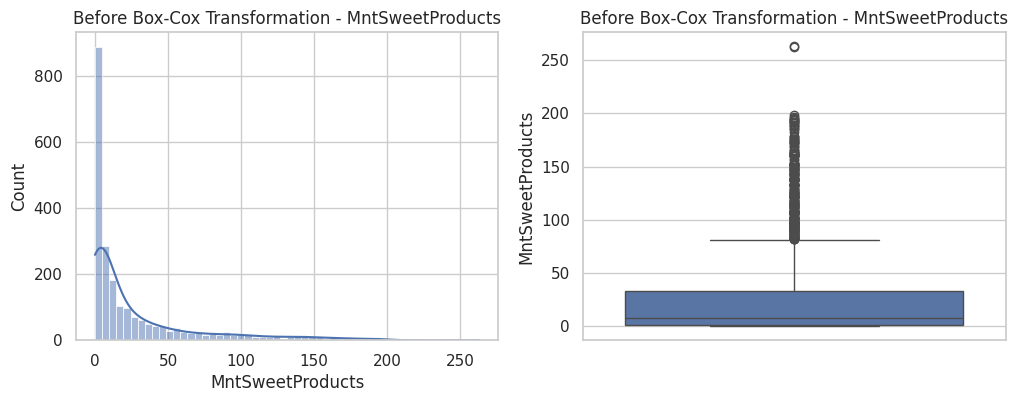

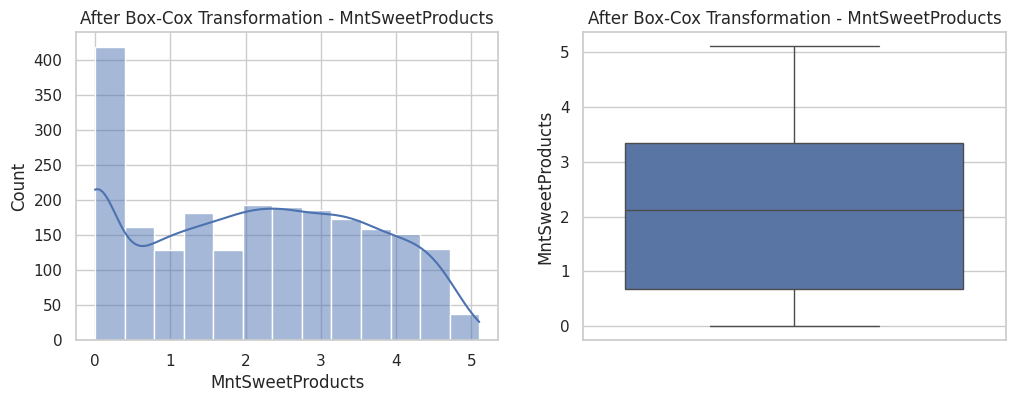

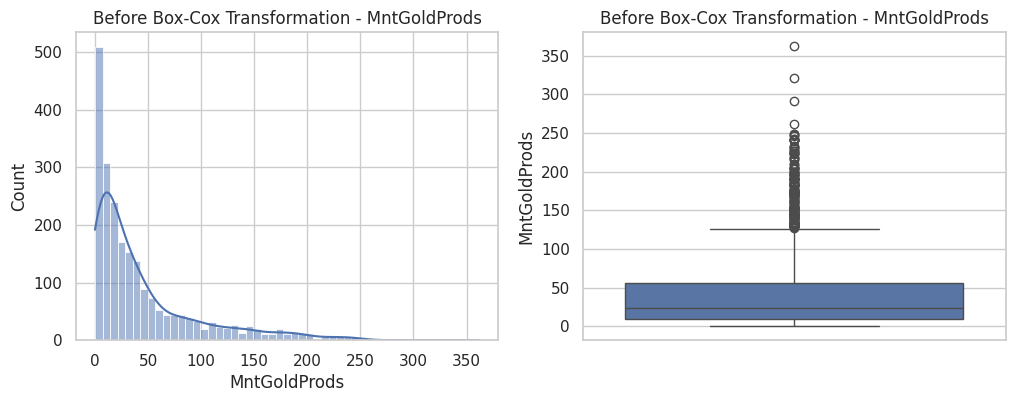

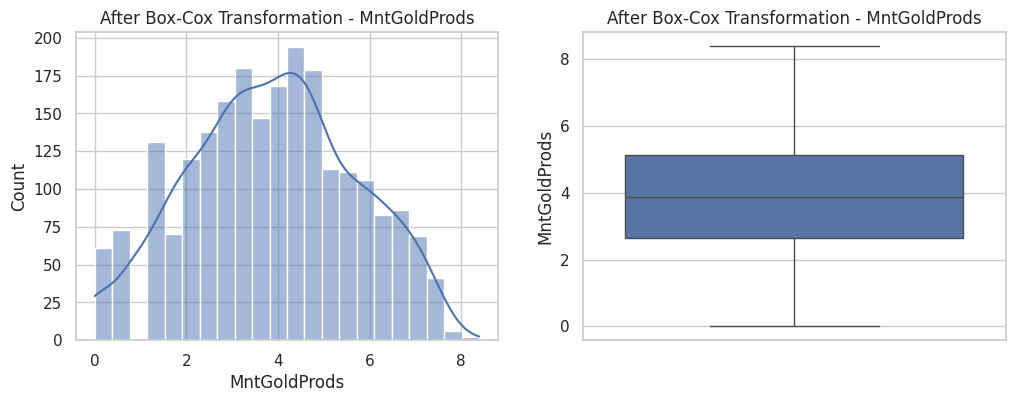

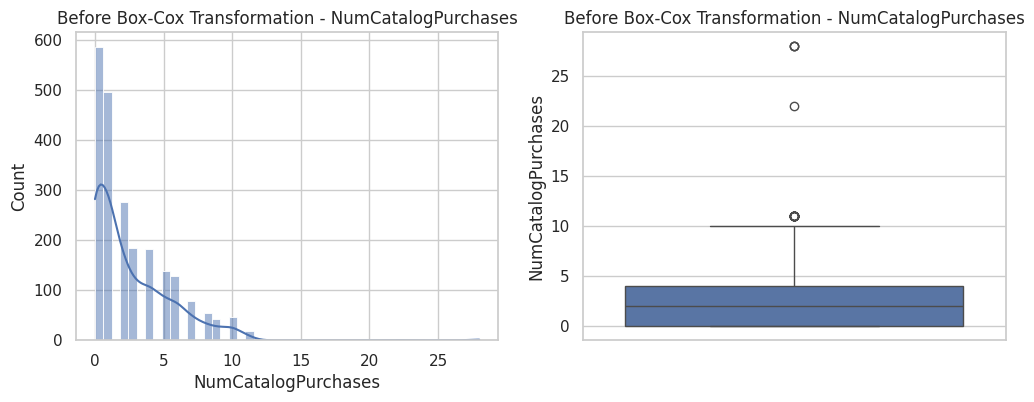

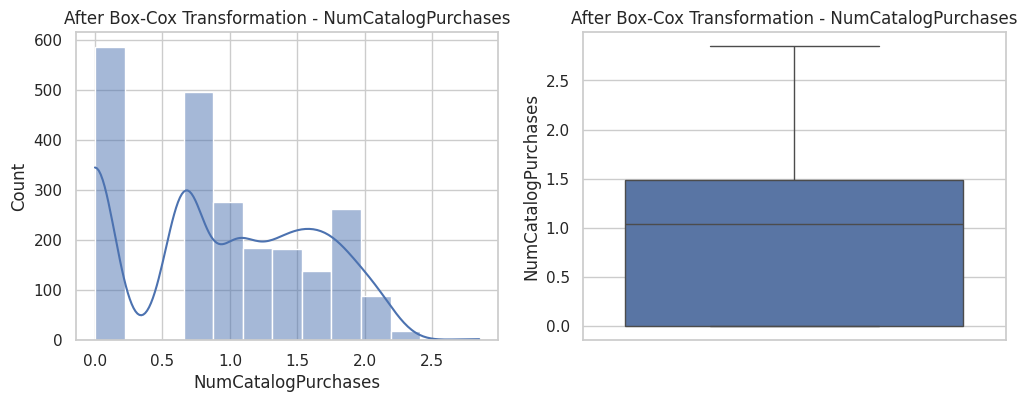

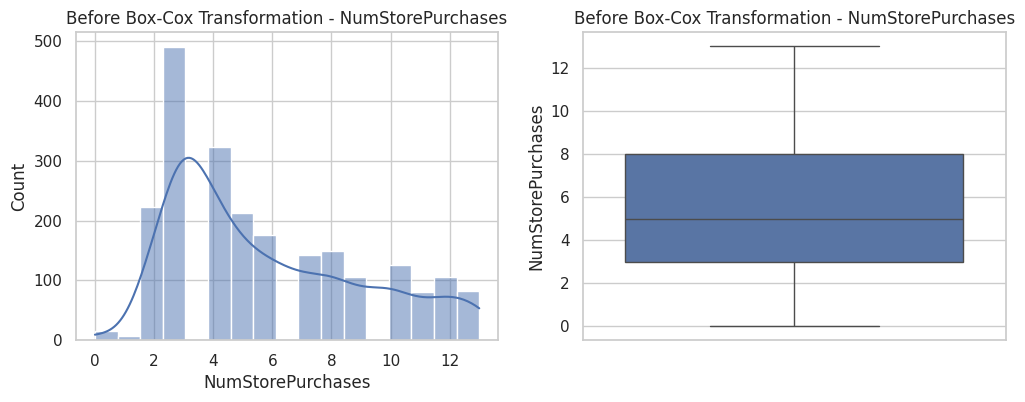

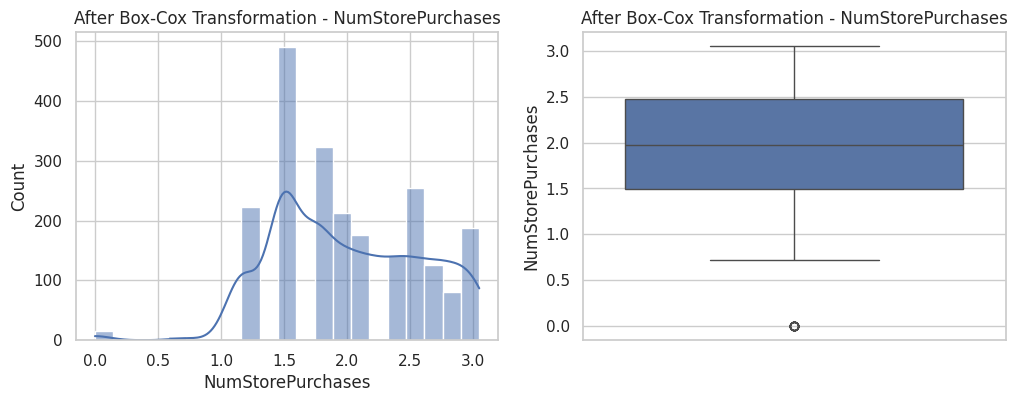

In [ ]:
# prompt: Transformame los datos de todas las columnas numéricas a parte Response, NumStorePurchase, Kidhome, Teenhome, Recency, DtCustomer, YearBirth,  con BoxCox y enseñame el histograma y el boxplot antes y después

from scipy.stats import boxcox
import numpy as np

# Assuming df_transformation is defined as in your previous code

# List of numerical columns to transform, excluding specified columns
numerical_cols = df_transformation.select_dtypes(include=np.number).columns.tolist()
cols_to_exclude = ['Response', 'NumWebVisitsMonth', 'NumWebPurchases', 'NumDealsPurchases', 'Kidhome',
                   'Teenhome', 'Recency', 'YearBirth', 'Dt_Customer', 'Age',
                   'Complain', 'Antiguedad']
cols_to_transform = [col for col in numerical_cols if col not in cols_to_exclude]

for col in cols_to_transform:
    # Create subplots for before and after transformation
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Plot before transformation
    sns.histplot(df_transformation[col], ax=axes[0], kde=True)
    axes[0].set_title(f'Before Box-Cox Transformation - {col}')
    sns.boxplot(y=df_transformation[col], ax=axes[1])
    axes[1].set_title(f'Before Box-Cox Transformation - {col}')


    # Apply Box-Cox transformation
    transformed_data, lambda_val = boxcox(df_transformation[col] + 1)  # Add 1 to handle zero and negative values
    df_transformation[col] = transformed_data

    # Plot after transformation
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df_transformation[col], ax=axes[0], kde=True)
    axes[0].set_title(f'After Box-Cox Transformation - {col}')

    sns.boxplot(y=df_transformation[col], ax=axes[1])
    axes[1].set_title(f'After Box-Cox Transformation - {col}')
    plt.show()


## Enconding de variables categoricas

### Label Encoding


El Label Encoding transforma las categorías de una variable en valores numéricos enteros.

Cada categoría única se reemplaza por un número, respetando su orden lógico o jerárquico (por ejemplo, "Bajo" → 0, "Medio" → 1, "Alto" → 2).

Esta técnica es ideal para atributos con un orden intrínseco, ya que, de lo contrario, el modelo podría interpretar relaciones numéricas inexistentes entre las categorías.

In [ ]:
#Visualizamos los valores unicos del atributo Educación
print(df_transformation['Education'].unique())

['Graduation' 'PhD' '2n Cycle' 'Master' 'Basic']


Una vez decidido el orden de las etiquetas, lo mapeamos en el dataset

In [ ]:
# Definir el orden jerárquico de los niveles educativos (de menor a mayor)
education_order = {
    'Basic': 0,
    '2n Cycle': 1,
    'Graduation': 2,
    'Master': 3,
    'PhD': 4
}

# Reemplazar las categorías en 'Education' con valores numéricos según la jerarquía
df_transformation['Education'] = df_transformation['Education'].map(education_order)



###One Hot Encoding

El One-Hot Encoding crea una columna binaria (0/1) para cada categoría única de una variable.

Se genera una nueva columna por cada valor unico, indicando la presencia (1) o ausencia (0) del mismo para la observación.

Es ideal para variables categóricas sin un orden lógico, pero puede aumentar significativamente el número de columnas en datasets con muchas categorías.

In [ ]:
# Crear variables dummy para la columna 'Marital_Status' con un prefijo
marital_status_dummies = pd.get_dummies(df_transformation['Marital_Status'], prefix='Marital_Status')

# Concatenar las nuevas columnas dummy al DataFrame original
df_transformation = pd.concat([df_transformation, marital_status_dummies], axis=1)

# Eliminar la columna original 'Marital_Status' del DataFrame
df_transformation = df_transformation.drop('Marital_Status', axis=1)

print(df_transformation.head())

   Education      Income  Kidhome  Teenhome  Recency   MntWines  MntFruits  \
0          2  416.838592        0         0        0   8.948248   4.324060   
1          2  346.436908        0         0        0  11.563868   1.741372   
2          2  374.030948        0         1        0   8.060083   2.388698   
3          2  266.077670        1         1        0   3.030105   0.000000   
4          2  219.198695        1         0        0   2.349814   2.708601   

   MntMeatProducts  MntFishProducts  MntSweetProducts  ...  NumWebVisitsMonth  \
0         6.498367         4.932622          4.826865  ...                  1   
1         4.445134         2.120343          0.000000  ...                  5   
2         4.354596         2.845619          1.079367  ...                  2   
3         0.700355         0.000000          0.000000  ...                  7   
4         3.378312         2.543462          0.000000  ...                  7   

   Response  Complain  Antiguedad  Age  Mari

## Normalización de datos

Normalizar es una operación muy importante para garantizar que todos los datos estén en la misma escala de referencia, evitando que las variables con escalas mayores tengan una influencia desproporcionada en el modelo.

Esto es especialmente crítico en algoritmos que dependen de la magnitud de las variables, como por ejemplo los métodos de clasificación basados en distancia: K-Nearest Neighbors (KNN) y SVM.

In [ ]:
# Selecciona las columnas a escalar (excluyendo las columnas especificadas)
columns_to_scale = [col for col in df_transformation.columns
                    if col not in ['Response', 'Marital_Status_Divorced',
                                   'Marital_Status_Married', 'Marital_Status_Single',
                                   'Marital_Status_Together', 'Marital_Status_Widow', 'Education', 'Complain']]
# Crea un objeto StandardScaler
scaler = StandardScaler()

# Copia el DataFrame original para no modificarlo directamente
df_standardizado = df_transformation.copy()

# Ajusta y transforma las columnas seleccionadas
df_standardizado[columns_to_scale] = scaler.fit_transform(df_transformation[columns_to_scale])

# Muestra las primeras filas del DataFrame escalado
print(df_standardizado.head())

# Lista de columnas excluidas del escalado
"Marital_Status_Divorced", "Marital_Status_Married", "Marital_Status_Single",
"Marital_Status_Together", "Marital_Status_Widow", "Education", "Complain"


   Education    Income   Kidhome  Teenhome   Recency  MntWines  MntFruits  \
0          2  1.337971 -0.826459 -0.929785 -1.697749  0.182338   1.507762   
1          2  0.323756 -0.826459 -0.929785 -1.697749  0.811965  -0.261326   
2          2  0.721279 -0.826459  0.906787 -1.697749 -0.031460   0.182079   
3          2 -0.833910  1.030790  0.906787 -1.697749 -1.242267  -1.454129   
4          2 -1.509254  1.030790 -0.929785 -1.697749 -1.406026   0.401206   

   MntMeatProducts  MntFishProducts  MntSweetProducts  ...  NumWebVisitsMonth  \
0         1.171895         1.331969          1.825377  ...          -1.781003   
1         0.008002        -0.288380         -1.433714  ...          -0.130983   
2        -0.043319         0.129502         -0.704927  ...          -1.368498   
3        -2.114757        -1.510057         -1.433714  ...           0.694027   
4        -0.596734        -0.044592         -1.433714  ...           0.694027   

   Response  Complain  Antiguedad       Age  Marit

('Marital_Status_Together', 'Marital_Status_Widow', 'Education', 'Complain')

# EXTRACCIÓN DE CONOCIMIENTOS EN BASE DE DATOS

## Modelos de clasificación

El dataset preprocesado, estandardizado y dividido entre variable objetivo y los otros atributos es el siguiente:

In [ ]:
# Separamos las características (features) y la variable objetivo (target)
X = df_standardizado.drop(columns=['Response'])  # Reemplaza 'Response' con el nombre correcto de tu variable objetivo
y = df_standardizado['Response']

## Arból de clasificación

Un árbol de clasificación es un modelo de aprendizaje supervisado utilizado para clasificar una variable a partir de un conjunto de datos con múltiples características.

La idea principal es dividir los datos en subconjuntos cada vez más pequeños basándose en preguntas o decisiones binarias que se representan como nodos en el árbol. Se empieza desde la caracteristica que divide mejor los datos, en función de un criterio de pureza (Gini o entropia).

Utilizamos el GridSearch para identificar los mejores parametros a aplicar al arból definitivo.

Estos parámetros controlan la complejidad y el crecimiento del árbol de decisión:

- criterion: Método para medir la impureza en la división (gini o entropy).
- max_depth: Profundidad máxima del árbol (evita sobreajuste).
- min_samples_split: Muestras mínimas para dividir un nodo.
- min_samples_leaf: Muestras mínimas en cada hoja.
- ccp_alpha: Parámetro de poda para reducir la complejidad del árbol.










### Resultados del arból de clasificación

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Mejores Parámetros: {'classifier__ccp_alpha': 0.003, 'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 20, 'classifier__min_samples_split': 10}
Mejor Puntuación en Validación Cruzada: 0.47345038466948103
Precisión en el Conjunto de Entrenamiento: 0.796420581655481


<Figure size 800x600 with 0 Axes>

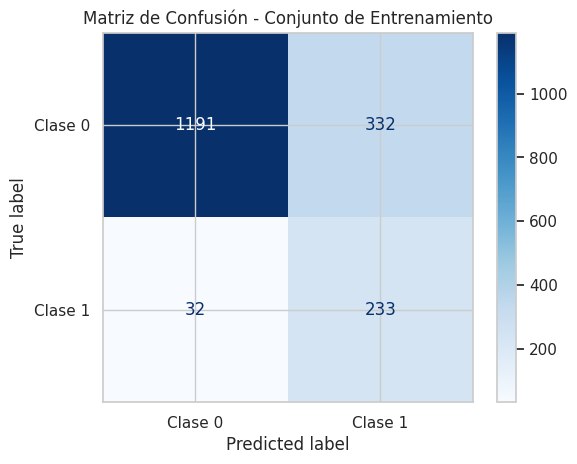

Informe de Clasificación - Conjunto de Entrenamiento:
              precision    recall  f1-score   support

     Clase 0       0.97      0.78      0.87      1523
     Clase 1       0.41      0.88      0.56       265

    accuracy                           0.80      1788
   macro avg       0.69      0.83      0.71      1788
weighted avg       0.89      0.80      0.82      1788

Precisión en el Conjunto de Prueba: 0.7633928571428571


<Figure size 800x600 with 0 Axes>

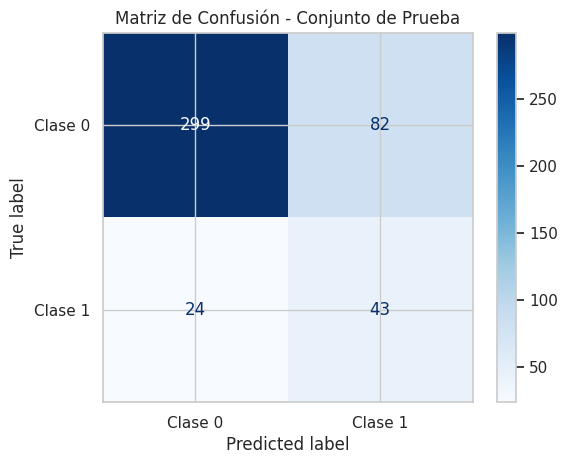

Informe de Clasificación - Conjunto de Prueba:
              precision    recall  f1-score   support

     Clase 0       0.93      0.78      0.85       381
     Clase 1       0.34      0.64      0.45        67

    accuracy                           0.76       448
   macro avg       0.63      0.71      0.65       448
weighted avg       0.84      0.76      0.79       448



In [ ]:
# División del conjunto de datos en entrenamiento y prueba con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Definición de la pipeline: primero se aplica RandomOverSampler y luego el Árbol de Decisión
pipeline = Pipeline([
    ('oversampler', RandomOverSampler(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Definición de la cuadrícula de hiperparámetros para el Árbol de Decisión
param_grid = {
    'classifier__criterion': ['gini', 'entropy'],  # Criterios de división del árbol
    'classifier__max_depth': [5, 10, 15],  # Profundidad máxima del árbol
    'classifier__min_samples_split': [10, 20],  # Mínimo de muestras para dividir un nodo
    'classifier__min_samples_leaf': [10, 20],  # Mínimo de muestras en cada hoja
    'classifier__ccp_alpha': [0.0, 0.001, 0.003, 0.01]  # Poda de complejidad
}

# Definición de la estrategia de validación cruzada: StratifiedKFold con 5 particiones
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configuración de GridSearchCV con la pipeline y la cuadrícula de hiperparámetros
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',  # Métrica de evaluación basada en la F1-score
    cv=cv,
    verbose=1,
    n_jobs=-1,    # Utiliza todos los núcleos disponibles
    refit=True    # Una vez finalizada la búsqueda, entrena el mejor modelo en todo el conjunto de entrenamiento
)

# Búsqueda de los mejores hiperparámetros (RandomOverSampler se aplicará en cada fold solo en datos de entrenamiento)
grid_search.fit(X_train, y_train)

# Impresión de los mejores parámetros y el mejor puntaje en validación cruzada
print("Mejores Parámetros:", grid_search.best_params_)
print("Mejor Puntuación en Validación Cruzada:", grid_search.best_score_)

# Obtención del mejor modelo (ya entrenado en el conjunto completo de entrenamiento gracias a refit=True)
best_model = grid_search.best_estimator_

# ---------------------------
# Evaluación en el conjunto de entrenamiento
# ---------------------------
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Precisión en el Conjunto de Entrenamiento:", train_accuracy)

# Cálculo de la matriz de confusión en el conjunto de entrenamiento
cm_train = confusion_matrix(y_train, y_train_pred)

# Visualización de la matriz de confusión en el conjunto de entrenamiento
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Clase 0', 'Clase 1'])
plt.figure(figsize=(8, 6))
disp_train.plot(cmap="Blues")
plt.title("Matriz de Confusión - Conjunto de Entrenamiento")
plt.show()

# Informe de clasificación en el conjunto de entrenamiento
print("Informe de Clasificación - Conjunto de Entrenamiento:")
print(classification_report(y_train, y_train_pred, target_names=['Clase 0', 'Clase 1']))


# ---------------------------
# Evaluación en el conjunto de prueba
# ---------------------------
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Precisión en el Conjunto de Prueba:", test_accuracy)

# Cálculo de la matriz de confusión en el conjunto de prueba
cm_test = confusion_matrix(y_test, y_test_pred)

# Visualización de la matriz de confusión en el conjunto de prueba
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Clase 0', 'Clase 1'])
plt.figure(figsize=(8, 6))
disp_test.plot(cmap="Blues")
plt.title("Matriz de Confusión - Conjunto de Prueba")
plt.show()

# Informe de clasificación en el conjunto de prueba
print("Informe de Clasificación - Conjunto de Prueba:")
print(classification_report(y_test, y_test_pred, target_names=['Clase 0', 'Clase 1']))



Parametros optimales encontrados:

- *ccp_alpha del clasificador*: Se ha ajustado a 0.003, lo que controla la complejidad del árbol de decisión al podar ramas con poca importancia, ayudando a evitar el sobreajuste.
- *criterio del clasificador*: Se utiliza el criterio 'gini', que es el método estándar para medir la impureza de las divisiones en el árbol, buscando siempre la partición que minimiza la impureza.
- *profundidad máxima del árbol*: Se establece un valor de 10, lo que limita cuánto puede crecer el árbol en profundidad, evitando que se ajuste demasiado a los datos de entrenamiento.
- *muestras mínimas por hoja*: Se establece en 20, lo que significa que cada hoja del árbol debe contener al menos 20 muestras, lo que ayuda a reducir la complejidad del modelo.
- *muestras mínimas por división*: Se configura en 10, lo que significa que para dividir un nodo, se requieren al menos 10 muestras, asegurando que las divisiones no sean demasiado específicas.

INSERIRE PICCOLA DESCRIZIONE SULLE MATRICI DI CONFUSIONE OTTENUTE

### Gráfico árbol de clasificación

En el siguiente gráfico es posible visualizar el mejor árbol obtenido a tráves de la configuración de sus diferentes parametros.
Se puede notar como se empieza a dividir un único atributo, siguiendo el criterio de pureza de Gini (como se vé en los parametros obtenidos con GridSearch) y se baja hasta llegar a la profundidad máxima permitida.

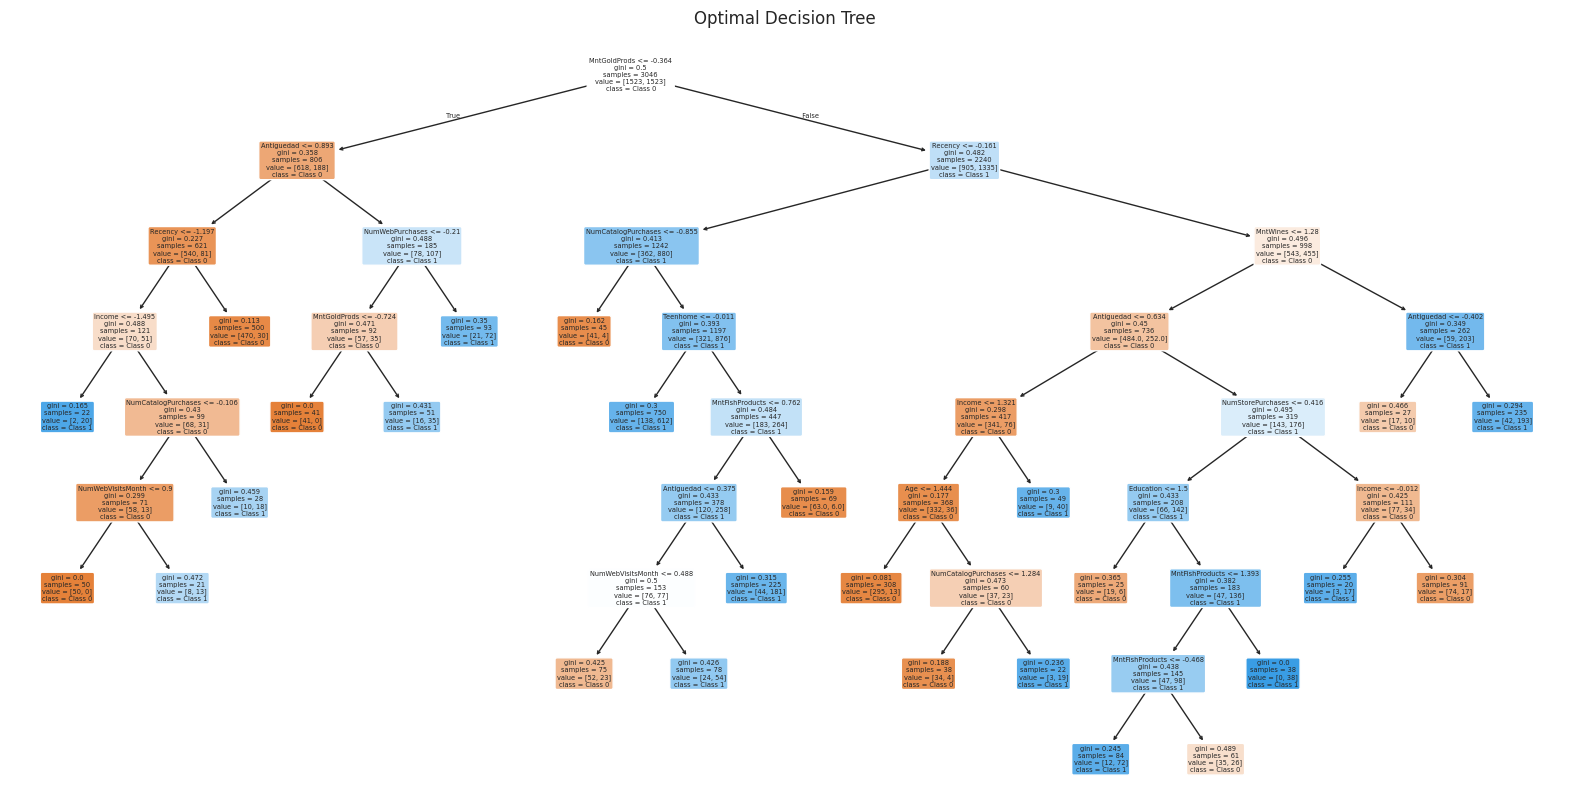

In [ ]:
from sklearn.tree import plot_tree  # Importa la función para graficar árboles de decisión
import matplotlib.pyplot as plt  # Importa la librería para gráficos

# Extrae el mejor modelo encontrado en la búsqueda en malla (GridSearchCV)

# Extrae el árbol de decisión del mejor modelo (último paso de la pipeline)
best_tree = best_model.named_steps['classifier']

# Configura el tamaño del gráfico
plt.figure(figsize=(20, 10))

# Dibuja el árbol de decisión
plot_tree(best_tree, filled=True, feature_names=X.columns, class_names=['Class 0', 'Class 1'], rounded=True)

# Agrega un título al gráfico
plt.title("Optimal Decision Tree")

# Muestra el gráfico
plt.show()


### Curva de aprendizaje del árbol de clasificación

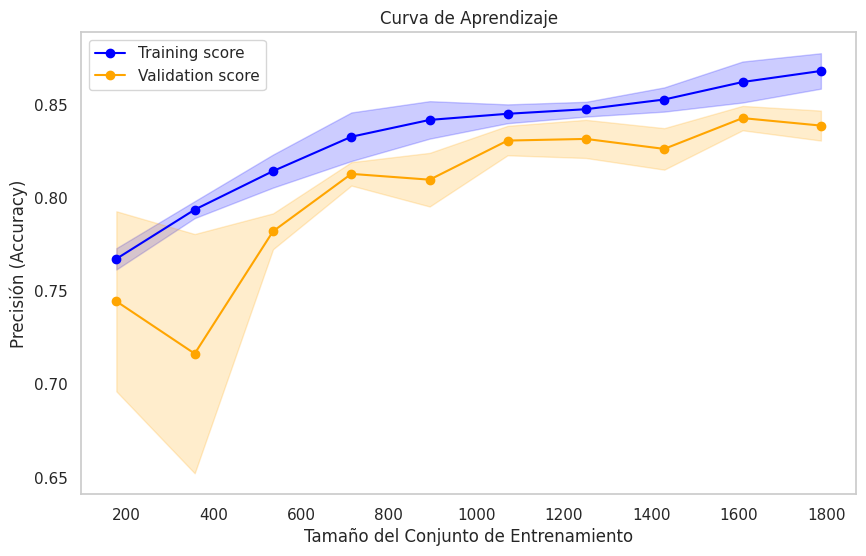

In [ ]:
from sklearn.model_selection import learning_curve  # Importa la función para generar la curva de aprendizaje
import numpy as np  # Importa NumPy para manipulación numérica

# Función para trazar la curva de aprendizaje
def plot_learning_curve(estimator, X, y, cv, scoring='accuracy'):
    """
    Genera y visualiza la curva de aprendizaje de un modelo.

    Parámetros:
    - estimator: Modelo de aprendizaje automático a evaluar.
    - X: Características del conjunto de datos.
    - y: Variable objetivo.
    - cv: Estrategia de validación cruzada.
    - scoring: Métrica de evaluación (por defecto, 'accuracy').
    """

    # Obtiene los valores de tamaño de entrenamiento, precisión en entrenamiento y en validación
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42  # Se usan tamaños de entrenamiento entre 10% y 100%
    )

    # Calcula la media y la desviación estándar de las puntuaciones en entrenamiento y validación
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Configura la figura del gráfico
    plt.figure(figsize=(10, 6))

    # Dibuja la curva para el conjunto de entrenamiento
    plt.plot(train_sizes, train_scores_mean, label="Training score", color="blue", marker='o')
    plt.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.2, color="blue")  # Rellena la región de incertidumbre

    # Dibuja la curva para el conjunto de validación
    plt.plot(train_sizes, test_scores_mean, label="Validation score", color="orange", marker='o')
    plt.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.2, color="orange")  # Rellena la región de incertidumbre

    # Configuración del gráfico
    plt.title("Curva de Aprendizaje")  # Título del gráfico
    plt.xlabel("Tamaño del Conjunto de Entrenamiento")  # Etiqueta del eje X
    plt.ylabel("Precisión (Accuracy)")  # Etiqueta del eje Y
    plt.legend(loc="best")  # Muestra la leyenda en la mejor ubicación
    plt.grid()  # Muestra la cuadrícula en el gráfico
    plt.show()  # Muestra el gráfico

# Llama a la función para visualizar la curva de aprendizaje del modelo Decision Tree
plot_learning_curve(best_tree, X, y, cv=cv)


Este grafico muestra la curva de accuracy en entrenamiento y validación. Se nota como inicia con valores con mucha discrepancia, porque el modelo empieza muy bien adaptandose al set de entrenamiento sin generalizar.

Pero poco a poco la curva relacionada a la validación sube, esto significa que el modelo empieza a generalizar los datos hasta un punto en el que la curva se estabiliza.

## Knn

Este modelo clasifica un dato nuevo según las clases de sus K vecinos más cercanos en el conjunto de entrenamiento.


### Determinar el número de k nearest neighbour

El codigo siguiente sirve para determinar cuantos elementos cercanos a k debemos considerar para nuestro modelo de clasificación.

Un **número bajo** dará resultados muy buenos en entrenamiento pero será poco capaz de generalizar, produciendo un overfitting importante ya que el modelo es demasiado sensible a los datos vistos en entrenamiento.

Por otro lado, un **numero alto**, puede resultar en malos resultados.

Por esta razón evaluamos el grafico siguiente y elegimos **un número de KNN que sea un compromiso adecuado** entre accuracy y capacidad de generalizar.

Después de aplicar el modelo, evaluaremos los resultados con un grafico que nos permitirá entender si nuestra elección resultó en un modelo capaz o no de generalizar adecuadamente.

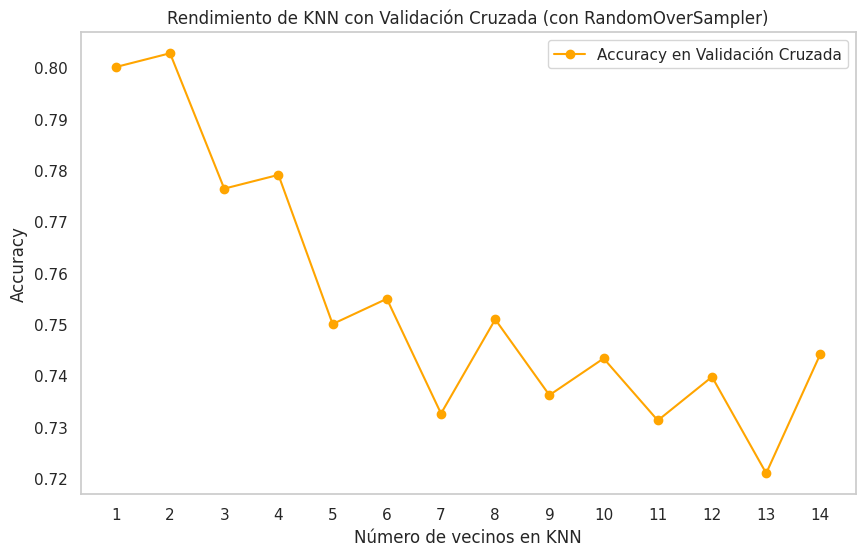

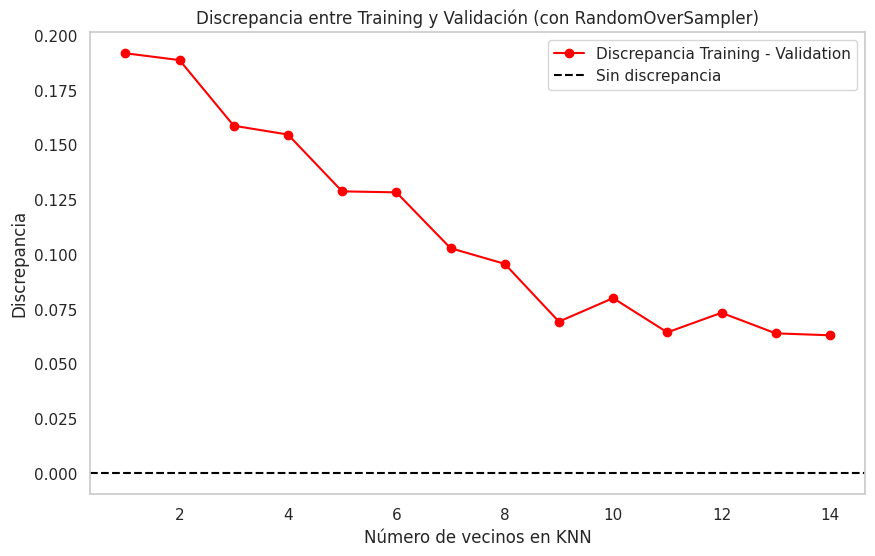

In [ ]:
# Lista de valores de k a probar
k_values = range(1, 15)
cv_accuracies = []
train_accuracies = []

# Para cada valor de k, creamos una pipeline que incluya RandomOverSampler y KNN
for k in k_values:
    # Crear pipeline: el oversampler se aplica SOLO en el entrenamiento (en cada fold de la validación cruzada)
    pipeline = Pipeline([
        ('oversampler', RandomOverSampler(random_state=42)),
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])

    # Calcular la precisión media usando validación cruzada con 6 folds
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    cv_accuracies.append(scores.mean())

    # Calcular la precisión en el conjunto de entrenamiento
    # Se entrena la pipeline sobre todo el dataset X e y (con oversampling integrado)
    pipeline.fit(X, y)
    train_accuracy = pipeline.score(X, y)
    train_accuracies.append(train_accuracy)

# Calcular la discrepancia entre la precisión de entrenamiento y la de validación
discrepancy = [train - cv for train, cv in zip(train_accuracies, cv_accuracies)]

# Gráfico de la precisión en validación cruzada
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_accuracies, label='Accuracy en Validación Cruzada', color='orange', marker='o')
plt.xlabel('Número de vecinos en KNN')
plt.ylabel('Accuracy')
plt.title('Rendimiento de KNN con Validación Cruzada (con RandomOverSampler)')
plt.xticks(k_values)  # Asegurar que los valores del eje x sean enteros
plt.legend()
plt.grid()
plt.show()

# Gráfico de la discrepancia entre el entrenamiento y la validación
plt.figure(figsize=(10, 6))
plt.plot(k_values, discrepancy, marker='o', label='Discrepancia Training - Validation', color='red')
plt.axhline(y=0, color='black', linestyle='--', label='Sin discrepancia')
plt.xlabel('Número de vecinos en KNN')
plt.ylabel('Discrepancia')
plt.title('Discrepancia entre Training y Validación (con RandomOverSampler)')
plt.legend()
plt.grid()
plt.show()


En el primer grafico podemos ver como los valores bajos de k performan muy bien, pero en el grafico sobre la discrepancia entre accuracy en entrenamiento y en validación se nota como con valores < 5 hay una diferencia significativa entre las dos accuracy.

Esto significa que con valores bajo de K, el modelo está en overfitting, o sea, performa muy bien sobre los datos de entrenamiento pero no generaliza (por esto hay discrepancia).

Con valores de k > 8, por lo contrario, el modelo está en underfitting, es decir, no tiene bastante datos para poder performar bien.


En este caso eligiremos KNN = 6

### Aplicamos el modelo KNN

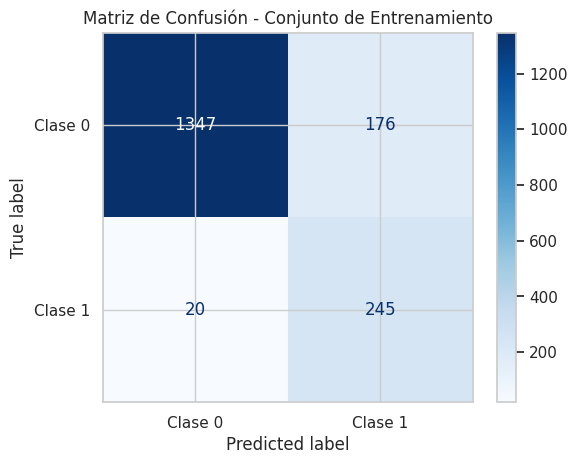

Reporte de Clasificación - Conjunto de Entrenamiento:
              precision    recall  f1-score   support

     Clase 0       0.99      0.88      0.93      1523
     Clase 1       0.58      0.92      0.71       265

    accuracy                           0.89      1788
   macro avg       0.78      0.90      0.82      1788
weighted avg       0.93      0.89      0.90      1788



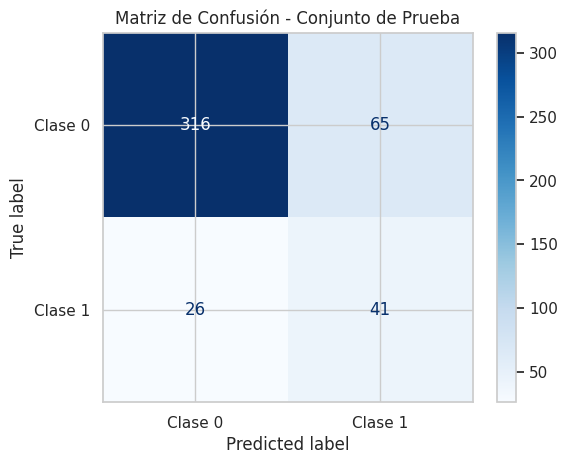

Reporte de Clasificación - Conjunto de Prueba:
              precision    recall  f1-score   support

     Clase 0       0.92      0.83      0.87       381
     Clase 1       0.39      0.61      0.47        67

    accuracy                           0.80       448
   macro avg       0.66      0.72      0.67       448
weighted avg       0.84      0.80      0.81       448



In [ ]:
# Subdivisión del conjunto de datos en conjunto de entrenamiento y de prueba con estratificación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Definición de la pipeline: primero se aplica RandomOverSampler y luego KNN
pipeline = Pipeline([
    ('oversampler', RandomOverSampler(random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=6))
])

# Entrenamiento de la pipeline en el conjunto de entrenamiento
pipeline.fit(X_train, y_train)

# ---------------------------
# Evaluación en el conjunto de entrenamiento
# ---------------------------
y_train_pred = pipeline.predict(X_train)

# Cálculo de la matriz de confusión en el conjunto de entrenamiento
cm_train = confusion_matrix(y_train, y_train_pred)

# Visualización de la matriz de confusión en el conjunto de entrenamiento
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Clase 0', 'Clase 1'])
disp_train.plot(cmap="Blues")
plt.title('Matriz de Confusión - Conjunto de Entrenamiento')
plt.show()

# Generación del reporte de clasificación en el conjunto de entrenamiento
print("Reporte de Clasificación - Conjunto de Entrenamiento:")
print(classification_report(y_train, y_train_pred, target_names=['Clase 0', 'Clase 1']))

# Predicciones sobre el conjunto de prueba
y_test_pred = pipeline.predict(X_test)

# Cálculo de la matriz de confusión en el conjunto de prueba
cm_test = confusion_matrix(y_test, y_test_pred)

# Visualización de la matriz de confusión en el conjunto de prueba
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Clase 0', 'Clase 1'])
disp_test.plot(cmap="Blues")
plt.title('Matriz de Confusión - Conjunto de Prueba')
plt.show()

# Generación del reporte de clasificación en el conjunto de prueba
print("Reporte de Clasificación - Conjunto de Prueba:")
print(classification_report(y_test, y_test_pred, target_names=['Clase 0', 'Clase 1']))



COMMENTARE I RISULTATI



## Naive Bayes

Naive Bayes es un modelo de clasificación basado en la teoría de probabilidad bayesiana que asume que las características son independientes entre sí.
Clasifica un dato calculando la probabilidad de que pertenezca a cada clase, dadas sus características, eligiendo la clase con la probabilidad más alta.

Sin embargo, su rendimiento puede verse afectado si las características no son realmente independientes.

En este caso, de momento que en el estudio de correlación había muchas relaciones que podrían no haberse perfectamente solucionado con las medidas actuadas (por no perder demasiado información), nos esperamos una performance menor en respecto a los otros modelos de clasificación operados.


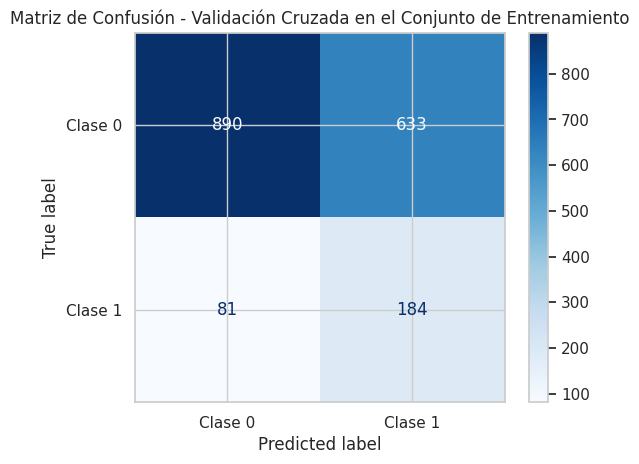

Reporte de Clasificación - Validación Cruzada en el Conjunto de Entrenamiento:
              precision    recall  f1-score   support

     Clase 0       0.92      0.58      0.71      1523
     Clase 1       0.23      0.69      0.34       265

    accuracy                           0.60      1788
   macro avg       0.57      0.64      0.53      1788
weighted avg       0.81      0.60      0.66      1788



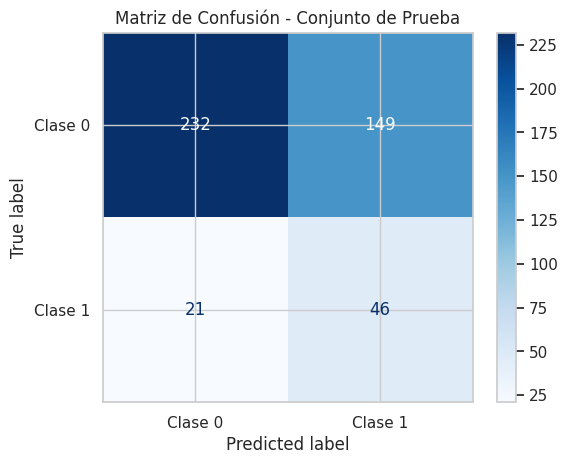

Reporte de Clasificación - Conjunto de Prueba:
              precision    recall  f1-score   support

     Clase 0       0.92      0.61      0.73       381
     Clase 1       0.24      0.69      0.35        67

    accuracy                           0.62       448
   macro avg       0.58      0.65      0.54       448
weighted avg       0.82      0.62      0.67       448



In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

# División del conjunto de datos en entrenamiento y prueba con estratificación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Construcción del pipeline:
# - 'oversampler': aplica el RandomOverSampler para replicar muestras de la clase minoritaria
# - 'nb': entrena el clasificador Naive Bayes (GaussianNB)
pipeline = Pipeline([
    ('oversampler', RandomOverSampler(random_state=42)),
    ('nb', GaussianNB())
])

# Definir la estrategia de validación cruzada (5 folds estratificados)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Realizar validación cruzada en el conjunto de entrenamiento y obtener predicciones
y_train_cv_pred = cross_val_predict(pipeline, X_train, y_train, cv=cv)

# Calcular y mostrar la matriz de confusión en la validación cruzada del conjunto de entrenamiento
cm_train_cv = confusion_matrix(y_train, y_train_cv_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train_cv, display_labels=['Clase 0', 'Clase 1'])
disp_train.plot(cmap="Blues")
plt.title('Matriz de Confusión - Validación Cruzada en el Conjunto de Entrenamiento')
plt.show()

# Mostrar el reporte de clasificación en la validación cruzada del conjunto de entrenamiento
print("Reporte de Clasificación - Validación Cruzada en el Conjunto de Entrenamiento:")
print(classification_report(y_train, y_train_cv_pred, target_names=['Clase 0', 'Clase 1']))

# -----------------------
# Evaluación en el Test Set
# -----------------------

# Entrenar el pipeline en el conjunto de entrenamiento completo
pipeline.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_test_pred = pipeline.predict(X_test)

# Calcular la matriz de confusión en el test set
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Clase 0', 'Clase 1'])
disp_test.plot(cmap="Blues")
plt.title('Matriz de Confusión - Conjunto de Prueba')
plt.show()

# Mostrar el reporte de clasificación en el conjunto de prueba
print("Reporte de Clasificación - Conjunto de Prueba:")
print(classification_report(y_test, y_test_pred, target_names=['Clase 0', 'Clase 1']))


## SVM

Este modelo es un algoritmo de clasificación supervisada utilizado para dividir datos en clases separadas mediante un **hiperplano**.

Este modelo busca maximizar el margen entre las clases, es decir, la distancia más grande entre los puntos más cercanos de cada clase y el hiperplano. SVM puede manejar tanto datos linealmente separables como no lineales, utilizando funciones kernel para proyectar los datos en un espacio de mayor dimensión.

Es especialmente eficaz cuando los datos tienen muchas características.

Las **funciones kernel** sirven para subir de dimensionalidad, transformando conjuntos de datos dificilmente separables linearmente en sus formas original.
Ejemplos de funciones kernel son:

- **polinomial**: mapea los datos a un espacio de mayor dimensión utilizando polinomios. Esto permite capturar relaciones no lineales de un grado especificado. Es útil cuando las fronteras entre las clases siguen patrones polinómicos.

- **RBF - Radial Basis Function**: este kernel es capaz de  manejar relaciones no lineales muy complejas. La transformación es basada en la distancia entre los puntos, lo que permite que los datos en espacios de alta dimensión sean separables de manera efectiva.

- **sigmoide**: este kernel está inspirado en la función sigmoide utilizada en redes neuronales. Al igual que la función sigmoide, produce una transformación que puede separar datos en espacios no lineales.

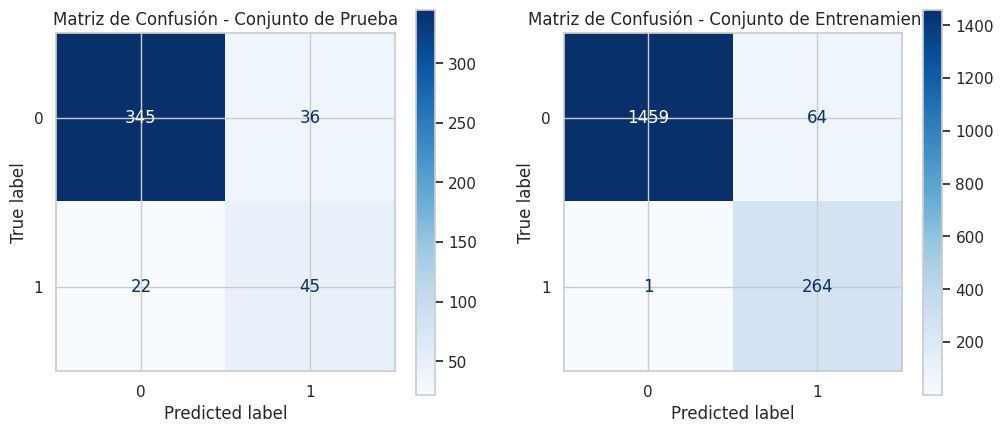

Reporte de clasificación en el conjunto de prueba:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92       381
           1       0.56      0.67      0.61        67

    accuracy                           0.87       448
   macro avg       0.75      0.79      0.77       448
weighted avg       0.88      0.87      0.88       448



In [ ]:
# División del conjunto de datos en conjunto de entrenamiento y prueba con estratificación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Definición de la pipeline que incluye el sobremuestreo y el clasificador SVM
pipeline = Pipeline([
    ('oversampler', RandomOverSampler(random_state=42)),  # Aplicación de RandomOverSampler para manejar el desbalanceo de clases
    ('svm', SVC(random_state=42))  # Clasificador SVM
])

# Definición de la cuadrícula de hiperparámetros para el SVM
param_grid = {
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Tipos de kernel a probar
    'svm__C': [0.1, 1, 10, 100],  # Valores del parámetro de regularización C
    'svm__gamma': ['scale', 'auto']  # Opciones para el parámetro gamma
}

# Definición de la estrategia de validación cruzada con StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Implementación de GridSearchCV para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Impresión de los mejores parámetros encontrados
best_params = grid_search.best_params_

# Crear un nuevo modelo con los mejores hiperparámetros encontrados
best_model = Pipeline([
    ('oversampler', RandomOverSampler(random_state=42)),
    ('svm', SVC(**{k.replace('svm__', ''): v for k, v in best_params.items()}, random_state=42))
])

# Entrenar el modelo con todos los datos de entrenamiento
best_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_test_pred = best_model.predict(X_test)

# Calcular la matriz de confusión en el conjunto de prueba
cm_test = confusion_matrix(y_test, y_test_pred)

# Predicciones en el conjunto de entrenamiento para evaluar overfitting
y_train_pred = best_model.predict(X_train)
cm_train = confusion_matrix(y_train, y_train_pred)

# Visualización de las matrices de confusión
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(confusion_matrix=cm_test).plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Matriz de Confusión - Conjunto de Prueba')

ConfusionMatrixDisplay(confusion_matrix=cm_train).plot(ax=axes[1], cmap='Blues')
axes[1].set_title('Matriz de Confusión - Conjunto de Entrenamiento')

plt.show()

# Generación del informe de clasificación en el conjunto de prueba
classification_rep_test = classification_report(y_test, y_test_pred)
print("Reporte de clasificación en el conjunto de prueba:\n", classification_rep_test)

In [ ]:
print(best_params)

{'svm__C': 10, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}


Como hicimos anteriormente, utilizamos la técnica de GridSearch para encontrar los parametros mejores para la generación del SVM más efectivo.

Los parametros aplicados han sido:
- *C* = 10. Controla la penalización por errores; un valor alto hace que el modelo sea más estricto en cuanto a los errores.
- *gamma* = 'auto'. Define la influencia de cada punto de datos; con 'auto', se ajusta en función de las características.
- *kernel* = 'rbf'. Utiliza el kernel RBF (Radial Basis Function) para encontrar fronteras no lineales entre las clases.